# Оптимизация потребления энергии на металлообрабатывающем заводе.

Задача - Построить модель, предсказывающую температуру металла.

# План работ:  
- [1. Первый взглад на данные.](#1_Первый_взглад_на_данные.)
- [2. Предобработка данных.](#2_Предобработка_данных.)
- [3. Задание.](#3_Задание.)
- [4. Подготовка данных.](#4_Подготовка_данных.)
- [5. Обучение модели.](#5_Обучение_модели.)
- [6. Выводы.](#6_Выводы.)

# Описание данных:

Данные состоят из файлов, полученных из разных источников:  

- `data_arc.csv` — данные об электродах;  
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);  
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);  
- `data_gas.csv` — данные о продувке сплава газом;  
- `data_temp.csv` — результаты измерения температуры;  
- `data_wire.csv` — данные о проволочных материалах (объём);  
- `data_wire_time.csv` — данные о проволочных материалах (время).  

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# 1. Первый взгляд на данные.<a id='1_Первый_взглад_на_данные.'></a>

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfr

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from yellowbrick.model_selection import FeatureImportances

pd.options.display.max_columns = 999

Загрузим данные:

In [2]:
data_arc = pd.read_csv('datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv')

### Посмотрим на данные:

### Сначала data_arc

In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропуски отстутсвуют.

In [4]:
data_arc.head(15)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Посмотрим на количество уникальных номеров партий:

In [5]:
len(data_arc['key'].unique())

3214

Столбцы с датой и временем стоит перевести в datetime из object.  

### Тперь data_bulk:

In [6]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Очень большое количество пропусков.

In [7]:
data_bulk.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [8]:
len(data_bulk['key'].unique())

3129

Число партий меньше, чем их число в таблице с электродами.

### Далее data_bulk_time

In [9]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [10]:
data_bulk_time.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [11]:
len(data_bulk_time['key'].unique())

3129

Количество данных идентично таблице data_bulk.  
Стоит перевести формат данных object в datetime.

### Далее data_gas:

In [12]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [13]:
data_gas.head(15)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [14]:
len(data_gas['key'].unique())

3239

Пропусков нет. Количество партий больше, чем в данных об электродах (3214).

### Далее data_temp:

In [15]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Есть пропуски в целевом признаке.

In [16]:
data_temp.head(15)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [17]:
len(data_temp['key'].unique())

3216

Столбцец с датой и временем стоит перевести в datetime из object. Количество партий чуть больше, чем в электродах.

### Далее data_wire:

In [18]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Много пропусков, как и в данных с сыпучими материалами.

In [19]:
data_wire.head(15)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
len(data_wire['key'].unique())

3081

Партий еще меньше.

### Далее data_wire_time:

In [21]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [22]:
data_wire_time.head(15)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
len(data_wire_time['key'].unique())

3081

Пропуски и количество партий аналогичны таблице data_wire

# 2. Предобработка данных.<a id='2_Предобработка_данных.'></a>

### Таблица data_arc:  

Переведём столбцы с датой и временем в datetime из object.  
Сгруппируем данные по ключу и дате начала нагрева и добавим столбец с продолжительностью нагрева (конец нагрева минус начало нагрева). Столбец конец нагрева больше не нужен.

In [24]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [25]:
data_arc['Время_нагрева_дугой'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds / 60

Присутсвует 1 строка с отрицательной реактивной мощностью. Скорее всего выброс.

In [26]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время_нагрева_дугой
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,1.816667


Заменим это значение на среднее Реактивной мощности в этой партии. Медианой заполнять не нужно, т. к. заполнение медианой уберегает от выбросов, а в этой партии у нас больше нет выбросов.

In [27]:
x = data_arc.query('key == 2116')
x = x[x['Реактивная мощность'] > 0]['Реактивная мощность'].mean()
x

0.30442937216666666

In [28]:
data_arc.loc[9780, 'Реактивная мощность'] = x

In [29]:
data_arc.loc[9780]['Реактивная мощность']

0.30442937216666666

In [30]:
data_arc.index = data_arc['key']
data_arc.drop(['key', 'Конец нагрева дугой'], axis=1, inplace=True)

### Таблица data_bulk:  

Сделаем key индексом.  

In [31]:
data_bulk.index = data_bulk['key']
data_bulk.drop(['key'], axis=1, inplace=True)
data_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


### Далее data_bulk_time:

Сделаем key индексом.  
Переведём столбцы с датой и временем в datetime из object.  

In [32]:
data_bulk_time.index = data_bulk_time['key']
data_bulk_time.drop(['key'], axis=1, inplace=True)

In [33]:
for i in data_bulk_time:
    data_bulk_time[i] = pd.to_datetime(data_bulk_time[i])
data_bulk_time.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


### Далее data_gas:

Сделаем key индексом

In [34]:
data_gas.index = data_gas['key']
data_gas.drop(['key'], axis=1, inplace=True)
data_gas.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


### Далее data_temp:

Переведём Время замера в datetime из object.  
Сделаем key индексом:



In [35]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [36]:
data_temp.index = data_temp['key']
data_temp.drop(['key'], axis=1, inplace=True)

### Далее data_wire:

Сделаем key индексом:

In [37]:
data_wire.index = data_wire['key']
data_wire.drop(['key'], axis=1, inplace=True)
data_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


### Далее data_wire_time:

Сделаем key индексом и переведём дату в datetime:

In [39]:
data_wire_time.index = data_wire_time['key']
data_wire_time.drop(['key'], axis=1, inplace=True)

In [40]:
for i in data_wire_time:
    data_wire_time[i] = pd.to_datetime(data_wire_time[i])
data_wire_time.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


# 3. Задание.<a id='3_Задание.'></a>

Выясним суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов; количество запусков нагрева электродами; среднее соотношение потребления активной и реактивной мощности.

In [41]:
for row in data_arc.index:
    data_arc.loc[row, 'Суммарное_время'] = data_arc.query('index == @row')['Время_нагрева_дугой'].sum()
    data_arc.loc[row, 'Количество_запусков'] = data_arc.query('index == @row')['Время_нагрева_дугой'].count()
    data_arc.loc[row, 'Среднее_соотношение'] = ((data_arc.query('index == @row')['Активная мощность'] ** 2 + data_arc.query('index == @row')['Реактивная мощность'] ** 2) ** 0.5).mean()
data_arc.head(7)

,Начало нагрева дугой,Активная мощность,Реактивная мощность,Время_нагрева_дугой,Суммарное_время,Количество_запусков,Среднее_соотношение
key,,,,,,,
1,2019-05-03 11:02:14,0.976059,0.687084,3.800000,18.300000,5.0,1.165279
1,2019-05-03 11:07:28,0.805607,0.520285,3.083333,18.300000,5.0,1.165279
1,2019-05-03 11:11:44,0.744363,0.498805,2.866667,18.300000,5.0,1.165279
1,2019-05-03 11:18:14,1.659363,1.062669,6.083333,18.300000,5.0,1.165279
1,2019-05-03 11:26:09,0.692755,0.414397,2.466667,18.300000,5.0,1.165279
2,2019-05-03 11:34:14,0.438063,0.283043,2.283333,13.516667,4.0,0.912304
2,2019-05-03 11:38:50,1.296415,0.892914,5.633333,13.516667,4.0,0.912304


Выясним длительность времени между первым и последним замером температуры для каждой партии:

In [42]:
for row in data_temp.index:
    data_temp.loc[row, 'Длительность_между_замерами'] = (data_temp.query('index == @row')['Время замера'].max() - data_temp.query('index == @row')['Время замера'].min()).seconds / 60
data_temp.head(7)

,Время замера,Температура,Длительность_между_замерами
key,,,
1,2019-05-03 11:16:18,1571.0,14.35
1,2019-05-03 11:25:53,1604.0,14.35
1,2019-05-03 11:29:11,1618.0,14.35
1,2019-05-03 11:30:01,1601.0,14.35
1,2019-05-03 11:30:39,1613.0,14.35
2,2019-05-03 11:37:27,1581.0,21.75
2,2019-05-03 11:38:00,1577.0,21.75


По всем полученным столбцам вычислим статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.  

Сначала длительность между первым и последним замером в данных о температуре:

In [43]:
d_temp_mean_time = data_temp['Длительность_между_замерами'].mean()
d_temp_min_time = data_temp['Длительность_между_замерами'].min()
d_temp_max_time = data_temp['Длительность_между_замерами'].max()
d_temp_median_time = data_temp['Длительность_между_замерами'].median()
d_temp_Q25_time = data_temp['Длительность_между_замерами'].quantile(0.25)
d_temp_Q75_time = data_temp['Длительность_между_замерами'].quantile(0.75)
print('Средняя длительность между первым и последним замером в данных о температуре = {:.0f} минуты.'.format(d_temp_mean_time))
print('Минимальная длительность = {:.0f} минуты.'.format(d_temp_min_time))
print('Максимальная длительность = {:.0f} минут.'.format(d_temp_max_time))
print('Медианная длительность = {:.0f} минуты.'.format(d_temp_median_time))
print('25% квартиль = {:.0f} минуты.'.format(d_temp_Q25_time))
print('75% квартиль = {:.0f} минуты.'.format(d_temp_Q75_time))

Средняя длительность между первым и последним замером в данных о температуре = 35 минуты.
Минимальная длительность = 0 минуты.
Максимальная длительность = 392 минут.
Медианная длительность = 29 минуты.
25% квартиль = 22 минуты.
75% квартиль = 41 минуты.


Теперь посчитаем те же данные для суммарного времени нагрева дугой, количества запусков нагрева и среднего соотношения активной и реактивной мощности:

In [44]:
data_arc_mean_sum_time = data_arc['Суммарное_время'].mean()
data_arc_min_sum_time = data_arc['Суммарное_время'].min()
data_arc_max_sum_time = data_arc['Суммарное_время'].max()
data_arc_median_sum_time = data_arc['Суммарное_время'].median()
data_arc_Q25_sum_time = data_arc['Суммарное_время'].quantile(0.25)
data_arc_Q75_sum_time = data_arc['Суммарное_время'].quantile(0.75)
print('Среднее время нагрева дугой = {:.0f} минуты.'.format(data_arc_mean_sum_time))
print('Минимальная длительность = {:.0f} минуты.'.format(data_arc_min_sum_time))
print('Максимальная длительность = {:.0f} минут.'.format(data_arc_max_sum_time))
print('Медианная длительность = {:.0f} минуты.'.format(data_arc_median_sum_time))
print('25% квартиль = {:.0f} минуты.'.format(data_arc_Q25_sum_time))
print('75% квартиль = {:.0f} минуты.'.format(data_arc_Q75_sum_time))
print()

data_arc_mean_number_launches = data_arc['Количество_запусков'].mean()
data_arc_min_number_launches = data_arc['Количество_запусков'].min()
data_arc_max_number_launches = data_arc['Количество_запусков'].max()
data_arc_median_number_launches = data_arc['Количество_запусков'].median()
data_arc_Q25_number_launches = data_arc['Количество_запусков'].quantile(0.25)
data_arc_Q75_number_launches = data_arc['Количество_запусков'].quantile(0.75)
print('Среднее количество запусков = {:.0f} минуты.'.format(data_arc_mean_number_launches))
print('Минимальное количество = {:.0f} минуты.'.format(data_arc_min_number_launches))
print('Максимальное количество = {:.0f} минут.'.format(data_arc_max_number_launches))
print('Медианное количество = {:.0f} минуты.'.format(data_arc_median_number_launches))
print('25% квартиль = {:.0f} минуты.'.format(data_arc_Q25_number_launches))
print('75% квартиль = {:.0f} минуты.'.format(data_arc_Q75_number_launches))
print()

data_arc_mean_power_ratio = data_arc['Среднее_соотношение'].mean()
data_arc_min_power_ratio = data_arc['Среднее_соотношение'].min()
data_arc_max_power_ratio = data_arc['Среднее_соотношение'].max()
data_arc_median_power_ratio = data_arc['Среднее_соотношение'].median()
data_arc_Q25_power_ratio = data_arc['Среднее_соотношение'].quantile(0.25)
data_arc_Q75_power_ratio = data_arc['Среднее_соотношение'].quantile(0.75)
print('Среднее соотношение активной и реактивной мощности всей таблицы = {:.0f} минуты.'.format(data_arc_mean_power_ratio))
print('Минимальное соотношение = {:.0f} минуты.'.format(data_arc_min_power_ratio))
print('Максимальное соотношение = {:.0f} минут.'.format(data_arc_max_power_ratio))
print('Медианное соотношение = {:.0f} минуты.'.format(data_arc_median_power_ratio))
print('25% квартиль = {:.0f} минуты.'.format(data_arc_Q25_power_ratio))
print('75% квартиль = {:.0f} минуты.'.format(data_arc_Q75_power_ratio))

Среднее время нагрева дугой = 15 минуты.
Минимальная длительность = 1 минуты.
Максимальная длительность = 70 минут.
Медианная длительность = 14 минуты.
25% квартиль = 11 минуты.
75% квартиль = 18 минуты.

Среднее количество запусков = 5 минуты.
Минимальное количество = 1 минуты.
Максимальное количество = 16 минут.
Медианное количество = 5 минуты.
25% квартиль = 4 минуты.
75% квартиль = 6 минуты.

Среднее соотношение активной и реактивной мощности всей таблицы = 1 минуты.
Минимальное соотношение = 0 минуты.
Максимальное соотношение = 2 минут.
Медианное соотношение = 1 минуты.
25% квартиль = 1 минуты.
75% квартиль = 1 минуты.


# Посмотрим на распределения данных:

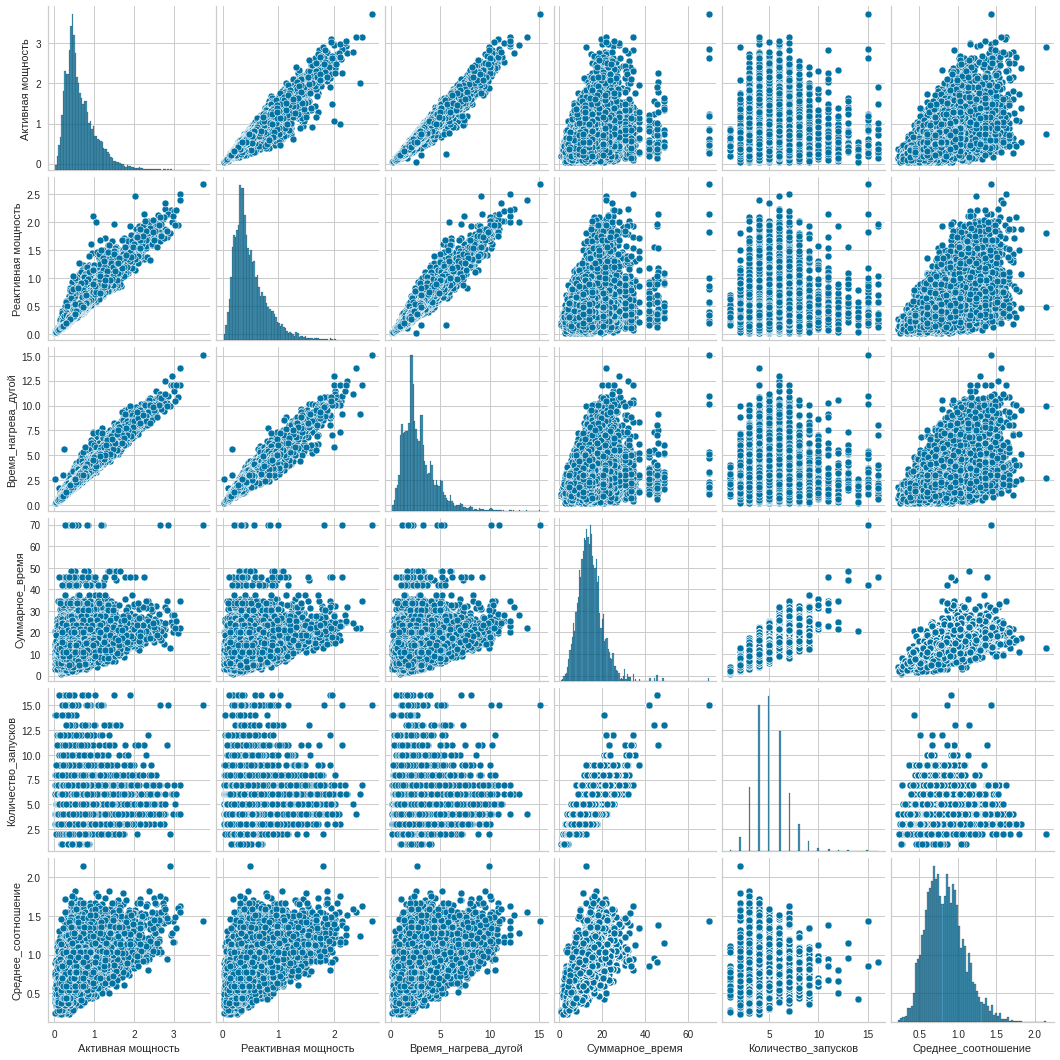

In [45]:
sns.pairplot(data_arc)

In [46]:
data_arc.head(3)

,Начало нагрева дугой,Активная мощность,Реактивная мощность,Время_нагрева_дугой,Суммарное_время,Количество_запусков,Среднее_соотношение
key,,,,,,,
1,2019-05-03 11:02:14,0.976059,0.687084,3.800000,18.3,5.0,1.165279
1,2019-05-03 11:07:28,0.805607,0.520285,3.083333,18.3,5.0,1.165279
1,2019-05-03 11:11:44,0.744363,0.498805,2.866667,18.3,5.0,1.165279


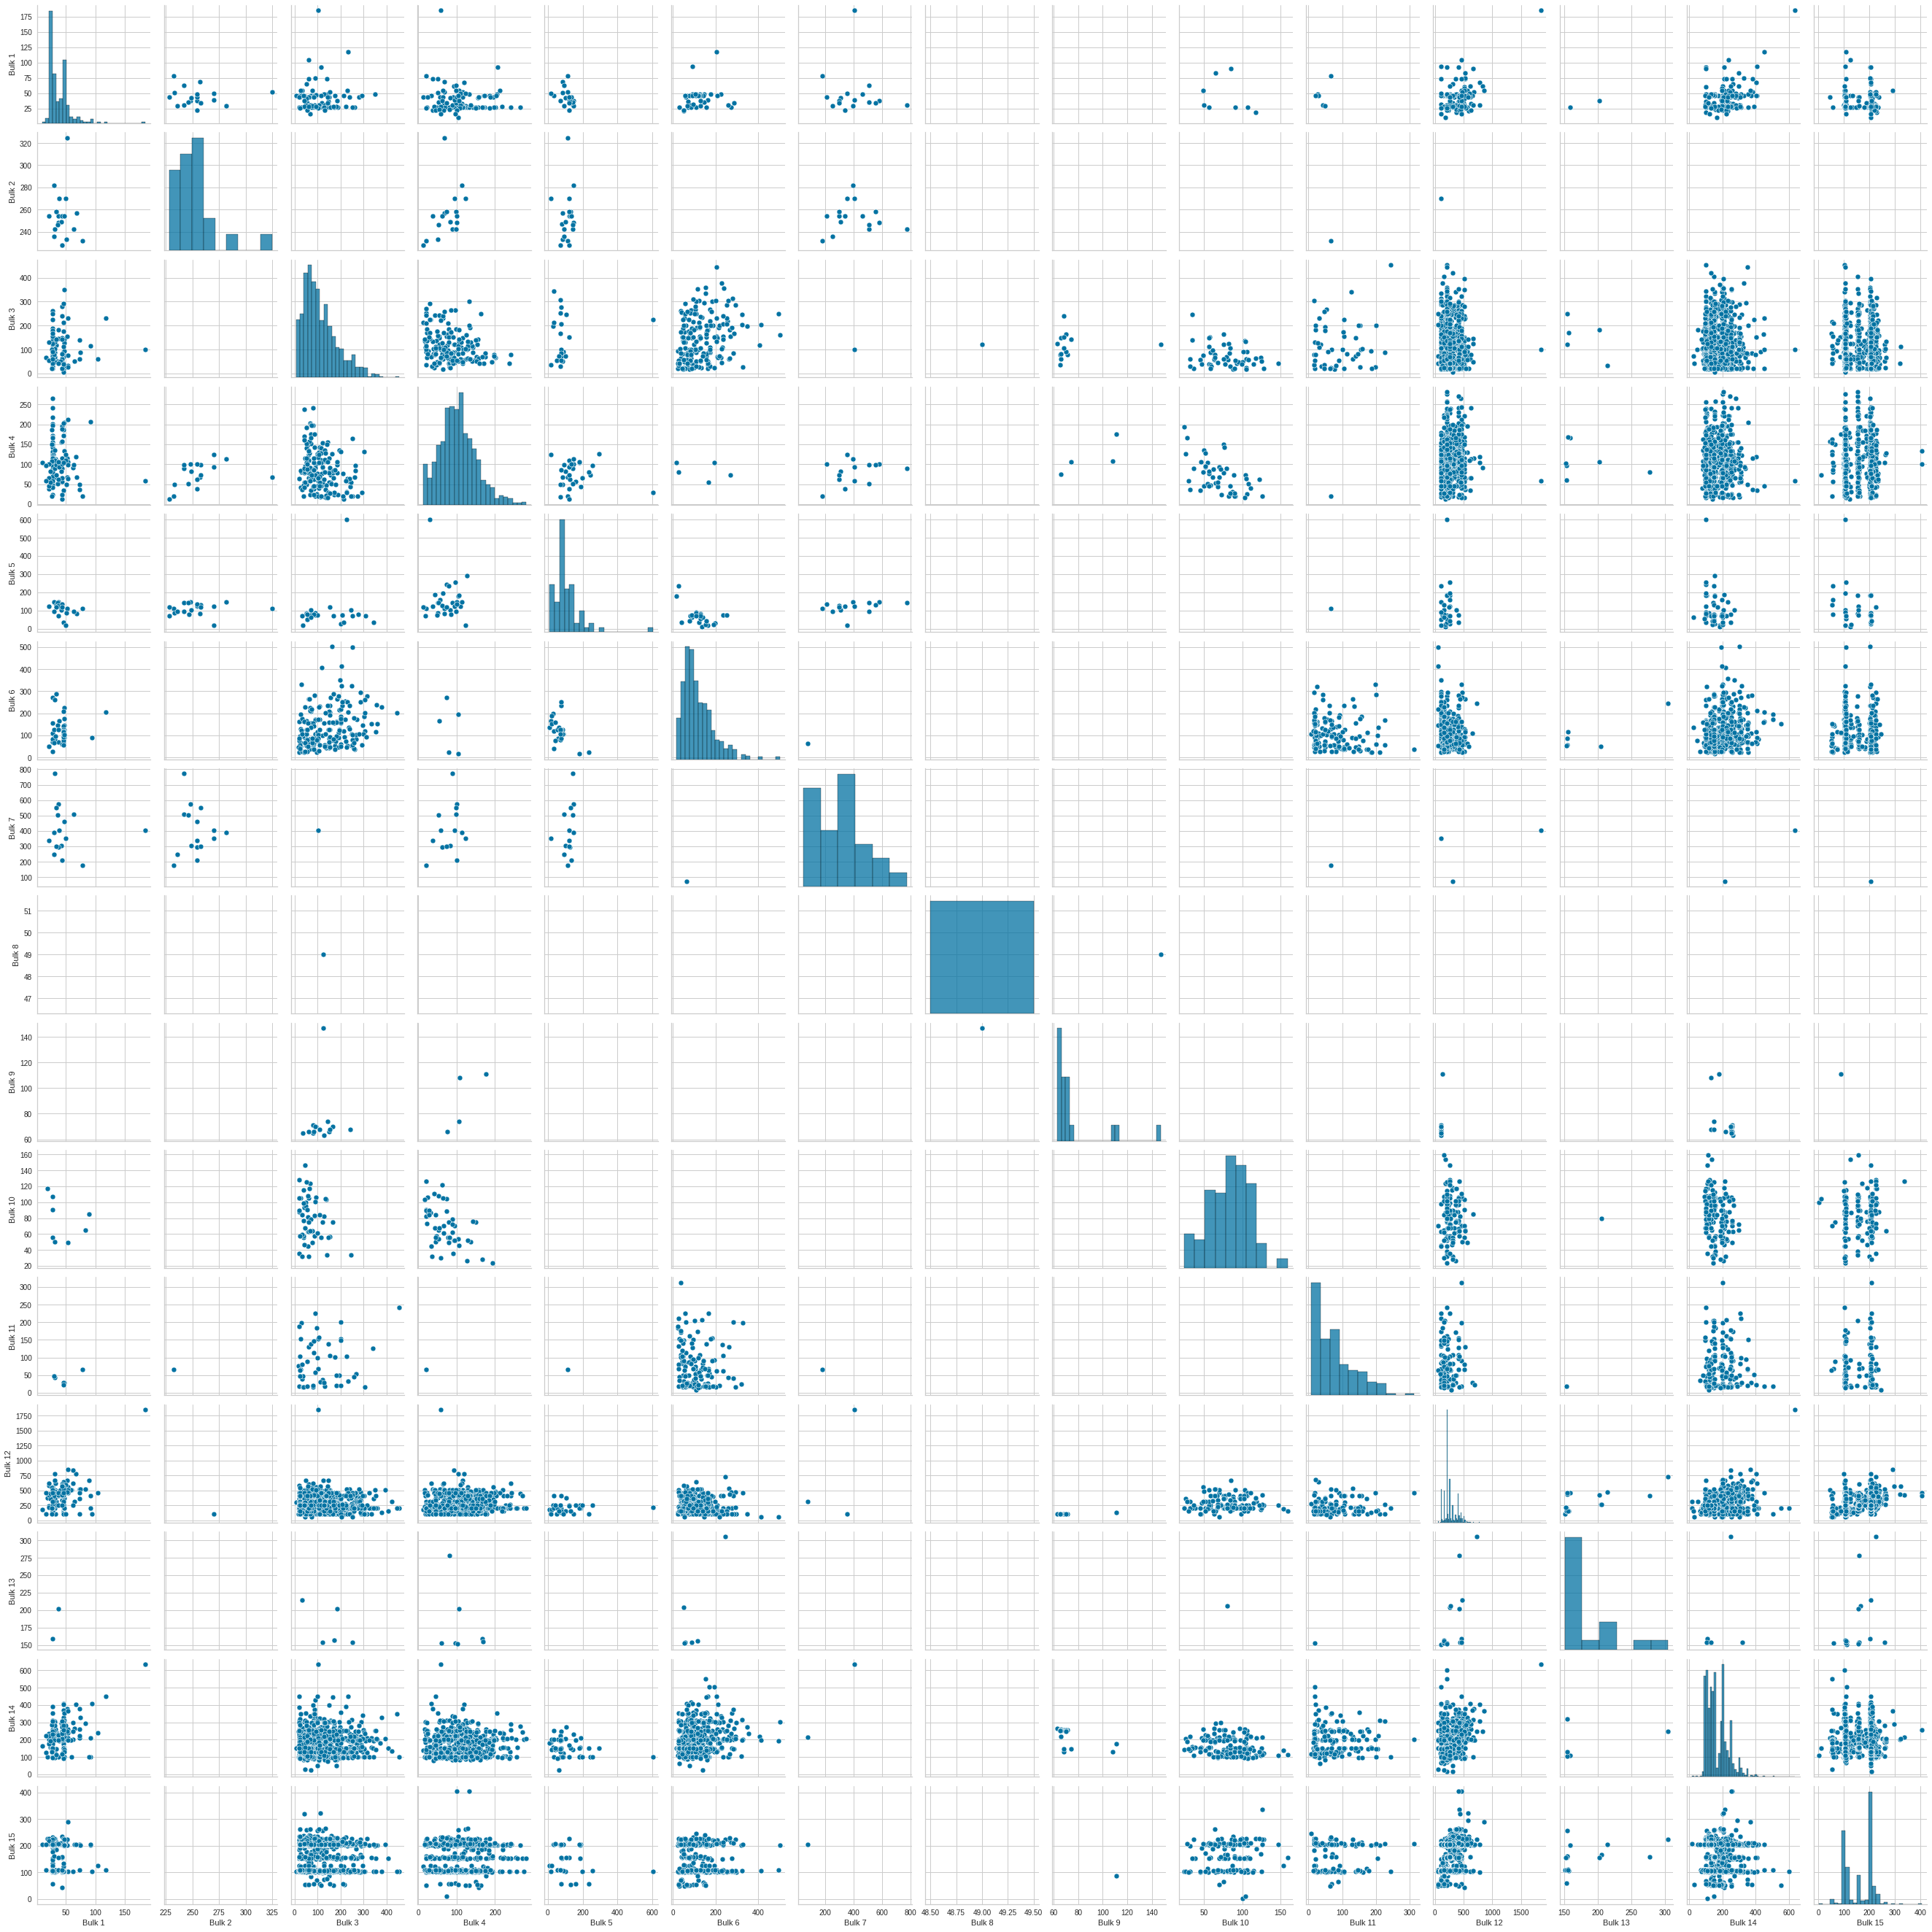

In [47]:
sns.pairplot(data_bulk)

In [48]:
data_bulk.head(3)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


array([[<AxesSubplot:title={'center':'Газ 1'}>]], dtype=object)

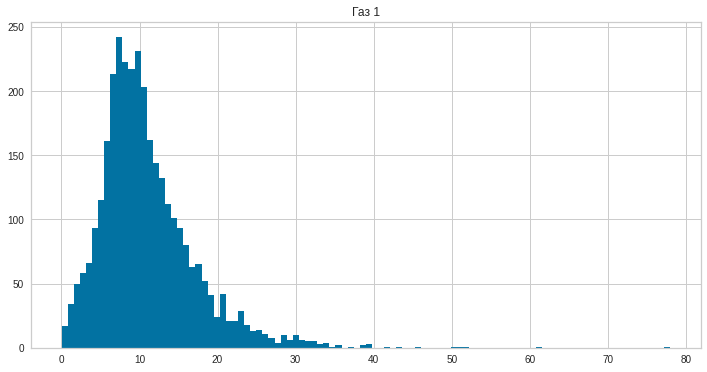

In [49]:
data_gas.hist(bins=100, figsize=(12, 6))

In [50]:
data_gas.head(3)

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793


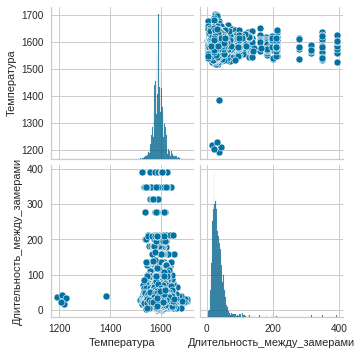

In [51]:
sns.pairplot(data_temp)

In [52]:
data_temp.head(3)

,Время замера,Температура,Длительность_между_замерами
key,,,
1,2019-05-03 11:16:18,1571.0,14.35
1,2019-05-03 11:25:53,1604.0,14.35
1,2019-05-03 11:29:11,1618.0,14.35


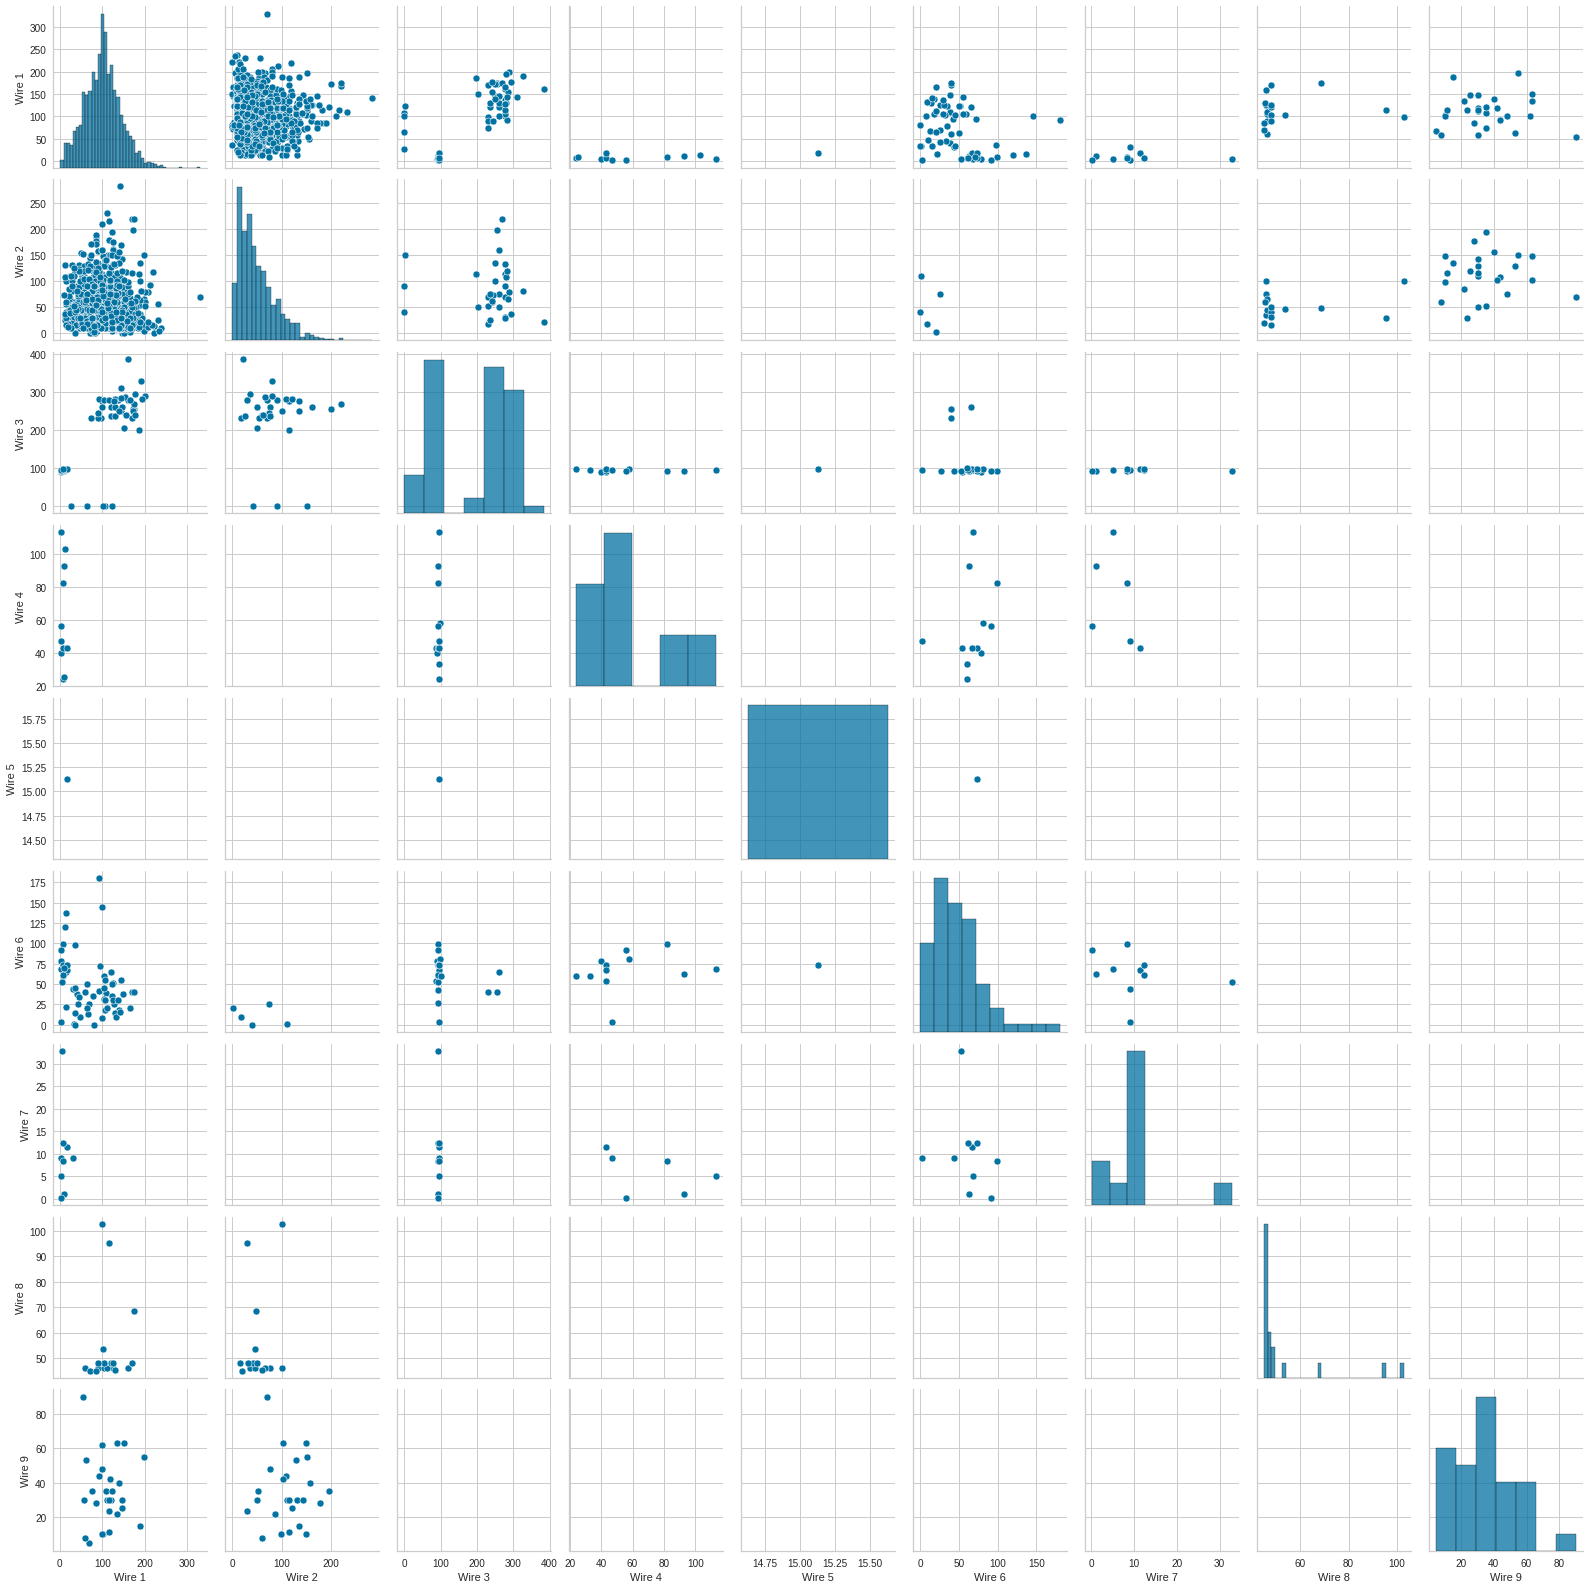

In [53]:
sns.pairplot(data_wire)

In [54]:
data_wire.head(3)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Подготовка данных.<a id='4_Подготовка_данных.'></a>

Склеим данные в одну таблицу:  
Временные данные о добавлении сыпучих метриалах и проволоке нам скорее всего не нужны, т.к. главное - факт и добавления в партию какого - либо материала и его объём, а не дата и время его дабавления.
Сначала данные о сыпучих материалах, проволке и газе:

In [55]:
data_additives_gas = data_wire.merge(data_bulk, left_index=True, right_index=True, how='outer')
data_additives_gas = data_additives_gas.merge(data_gas, left_index=True, right_index=True, how='outer')

In [56]:
display(data_additives_gas.head())
len(data_additives_gas)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
key,,,,,,,,,,,,,,,,,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,29.749986
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.554793
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.841219
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5.413692


3241

Обработаем данные по цлевому признаку.  
Посомтрим на качество данных тымпературы через длительность между замерами:

In [57]:
data_temp['Длительность_между_замерами'].describe()

count    15907.000000
mean        34.853260
std         26.892157
min          0.000000
25%         21.750000
50%         29.233333
75%         40.833333
max        392.283333
Name: Длительность_между_замерами, dtype: float64

(array([   6.,  103.,  311.,  842., 1602., 2132., 2006., 1838., 1343.,
        1246., 1142.,  815.,  587.,  607.,  292.,  178.,  150.,   64.,
          62.,   57.,   41.,   20.,   40.,   21.,   66.,   42.,   17.,
          28.,   20.,   11.,    5.,   13.,   39.,    0.,   11.,    5.,
           5.,    0.,    0.,    0.,    9.,    5.,    0.,    0.,    0.,
          16.,   16.,    0.,    0.,    0.,   10.,   16.,    0.,    8.,
          15.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    6.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    9.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,   15.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          15.]),
 array([  0.        ,   3.92283333,   7.84566667,  11.7685    ,
         15.69133333,  19.61416667,  23.537     ,  27.45983333,
         31.38266667,  35.3055    ,  39.22833333,  43.15116667,
         4

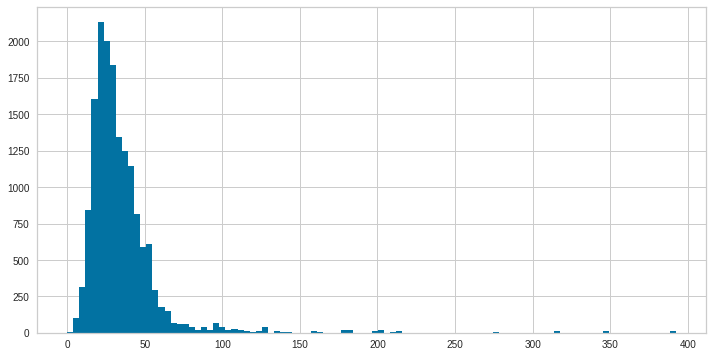

In [58]:
plt.figure(figsize=(12, 6))
plt.hist(data_temp['Длительность_между_замерами'], bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2415d81ac0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2415d901c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2415d81760>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2415d90880>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2415d90be0>],
 'means': []}

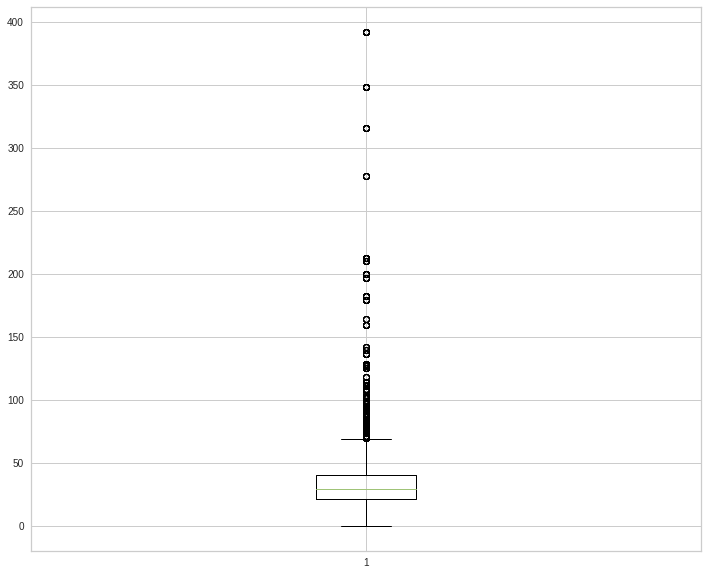

In [59]:
plt.figure(figsize=(12, 10))
plt.boxplot(data_temp['Длительность_между_замерами'])

Максимальные данные сильно выбиваются. Избавимся от выбросов с помощью ящика с усами:

In [60]:
Q1 = data_temp['Длительность_между_замерами'].quantile(0.25)
Q3 = data_temp['Длительность_между_замерами'].quantile(0.75)
IQR = Q3 - Q1
data_temp = data_temp.query('(@Q1 - 1.5 * @IQR) <= Длительность_между_замерами <= (@Q3 + 1.5 * @IQR)')

In [61]:
data_temp['Длительность_между_замерами'].describe()

count    15235.000000
mean        30.871910
std         12.482027
min          0.000000
25%         21.466667
50%         28.616667
75%         39.216667
max         68.933333
Name: Длительность_между_замерами, dtype: float64

Т.к. нам не будут известны промежуточные данные о температуре, следует оставить только данные с начальной и конечной температурой. Заполним пропуски в целевом признаки выбивающимся значением -1 и проверим всю таблицу на наличие первого и последнего замера в партии, а также, чтобы замеров было больше одного:

In [62]:
pd.options.mode.chained_assignment = None

In [63]:
data_temp['Температура'].fillna(-1, inplace=True)
for i in data_temp.index:
    data_temp.is_copy = False
    check_len = len(data_temp.query('index == @i and Температура != -1'))
    first = list(data_temp.query('index == @i')['Температура'])[0]
    last = list(data_temp.query('index == @i')['Температура'])[-1]
    if first != -1 and last != -1 and check_len > 1:
        data_temp.loc[i, 'no_one'] = True
        data_temp.loc[i, 'temp_first'] = first
        data_temp.loc[i, 'temp_last'] = last
    else:
        data_temp.loc[i, 'no_one'] = False
        data_temp.loc[i, 'temp_first'] = False
        data_temp.loc[i, 'temp_last'] = False

In [64]:
pd.options.mode.chained_assignment = 'warn'

Оставим данне с True:

In [65]:
data_temp = data_temp.query('no_one == True')
len(data_temp)

11760

In [66]:
display(data_temp.head())
display(data_temp.tail())

,Время замера,Температура,Длительность_между_замерами,no_one,temp_first,temp_last
key,,,,,,
1,2019-05-03 11:16:18,1571.0,14.35,True,1571,1613
1,2019-05-03 11:25:53,1604.0,14.35,True,1571,1613
1,2019-05-03 11:29:11,1618.0,14.35,True,1571,1613
1,2019-05-03 11:30:01,1601.0,14.35,True,1571,1613
1,2019-05-03 11:30:39,1613.0,14.35,True,1571,1613


,Время замера,Температура,Длительность_между_замерами,no_one,temp_first,temp_last
key,,,,,,
2498,2019-08-06 02:19:26,1593.0,21.70,True,1591,1594
2498,2019-08-06 02:25:31,1594.0,21.70,True,1591,1594
2499,2019-08-06 02:40:25,1569.0,20.05,True,1569,1603
2499,2019-08-06 02:54:24,1604.0,20.05,True,1569,1603
2499,2019-08-06 03:00:28,1603.0,20.05,True,1569,1603


Создадим новую таблицу с одной строкой на каждую партию для моделей:

In [67]:
pd.options.mode.chained_assignment = None

In [68]:
data_temp.rename(columns={'Время замера': 'Время_замера'}, inplace=True)
data_temp_mod = pd.DataFrame(columns=list(data_temp.columns))
for i in data_temp.index.unique():
    maxx = data_temp.query("index == @i")["Время_замера"].max()
    string = data_temp.query('key == @i and Время_замера == @maxx')
    data_temp_mod = data_temp_mod.append(string)
display(data_temp_mod.head())
display(data_temp_mod.tail())

,Время_замера,Температура,Длительность_между_замерами,no_one,temp_first,temp_last
1,2019-05-03 11:30:39,1613.0,14.350000,True,1571,1613
2,2019-05-03 11:59:12,1602.0,21.750000,True,1581,1602
3,2019-05-03 12:34:57,1599.0,21.666667,True,1596,1599
4,2019-05-03 12:59:25,1625.0,6.466667,True,1601,1625
5,2019-05-03 13:36:01,1602.0,12.700000,True,1576,1602


,Время_замера,Температура,Длительность_между_замерами,no_one,temp_first,temp_last
2495,2019-08-06 00:54:42,1591.0,18.950000,True,1570,1591
2496,2019-08-06 01:29:52,1591.0,26.966667,True,1554,1591
2497,2019-08-06 01:53:50,1589.0,11.950000,True,1571,1589
2498,2019-08-06 02:25:31,1594.0,21.700000,True,1591,1594
2499,2019-08-06 03:00:28,1603.0,20.050000,True,1569,1603


In [69]:
pd.options.mode.chained_assignment = 'warn'

In [70]:
len(data_temp_mod)

2413

Сбросим начальные данные о температуре и уже ненужный столбец no_one, а также время замера, т. к. эта задача не про временные ряды, и от даты и времени начала замера ничего не зависит:

In [71]:
data_temp_mod.drop(['Температура', 'Время_замера', 'no_one'], axis=1, inplace=True)  # 
data_temp_mod.index.name = 'key'
display(data_temp_mod.head())
display(data_temp_mod.tail())

,Длительность_между_замерами,temp_first,temp_last
key,,,
1,14.350000,1571,1613
2,21.750000,1581,1602
3,21.666667,1596,1599
4,6.466667,1601,1625
5,12.700000,1576,1602


,Длительность_между_замерами,temp_first,temp_last
key,,,
2495,18.950000,1570,1591
2496,26.966667,1554,1591
2497,11.950000,1571,1589
2498,21.700000,1591,1594
2499,20.050000,1569,1603


Соберём новую таблицу для моделей из data_arc:

In [72]:
data_arc.rename(columns={'Начало нагрева дугой': 'Начало_нагрева_дугой'}, inplace=True)
data_arc_mod = pd.DataFrame(columns=list(data_arc.columns))
for i in data_arc.index.unique():
    maxx = data_arc.query("index == @i")["Начало_нагрева_дугой"].max()
    string = data_arc.query('index == @i and Начало_нагрева_дугой == @maxx')
    data_arc_mod = data_arc_mod.append(string)
display(data_arc_mod.head())
display(data_arc_mod.tail())

,Начало_нагрева_дугой,Активная мощность,Реактивная мощность,Время_нагрева_дугой,Суммарное_время,Количество_запусков,Среднее_соотношение
1,2019-05-03 11:26:09,0.692755,0.414397,2.466667,18.300000,5.0,1.165279
2,2019-05-03 11:49:48,0.827743,0.516874,3.500000,13.516667,4.0,0.912304
3,2019-05-03 12:31:14,0.250280,0.155901,1.083333,10.916667,5.0,0.597907
4,2019-05-03 12:53:12,1.220955,0.754719,4.633333,12.350000,4.0,0.953741
5,2019-05-03 13:32:44,0.267457,0.181992,1.183333,14.483333,4.0,1.008939


,Начало_нагрева_дугой,Активная мощность,Реактивная мощность,Время_нагрева_дугой,Суммарное_время,Количество_запусков,Среднее_соотношение
3237,2019-08-31 23:01:32,0.606049,0.419084,2.266667,15.150000,5.0,0.968996
3238,2019-08-31 23:38:38,0.717559,0.520623,2.833333,9.100000,3.0,0.898847
3239,2019-09-01 02:13:38,0.488352,0.317727,2.083333,20.266667,8.0,0.701485
3240,2019-09-01 03:31:47,0.548882,0.416994,2.350000,13.983333,5.0,0.778371
3241,2019-09-01 04:34:47,0.306580,0.196708,1.350000,10.983333,5.0,0.599903


In [73]:
len(data_arc_mod)

3214

В таблице data_arc нам больше не нужны признаки Активная мощность и Реактивная мощность, т.к. у нас есть Среднее соотношение, которое напрямумую зависит от них. Также не нужен признак Время нагрева дугой и Начало_нагрева_дугой, т.к. есть суммарное время нагрева каждой партии.

In [74]:
data_arc_mod.index.name = 'key'
data_arc_mod.drop(['Начало_нагрева_дугой', 'Активная мощность', 'Реактивная мощность', 'Время_нагрева_дугой'], axis=1, inplace=True)

Объединим data_arc_mod и data_temp_mod обработанным индексам data_temp_mod:

In [75]:
data_arc_temp = data_temp_mod.merge(data_arc_mod, left_index=True, right_index=True, on='key', how='left')
display(data_arc_temp.head())
display(data_arc_temp.tail())

,Длительность_между_замерами,temp_first,temp_last,Суммарное_время,Количество_запусков,Среднее_соотношение
key,,,,,,
1,14.350000,1571,1613,13.516667,4.0,0.912304
2,21.750000,1581,1602,10.916667,5.0,0.597907
3,21.666667,1596,1599,12.350000,4.0,0.953741
4,6.466667,1601,1625,14.483333,4.0,1.008939
5,12.700000,1576,1602,15.866667,4.0,1.196709


,Длительность_между_замерами,temp_first,temp_last,Суммарное_время,Количество_запусков,Среднее_соотношение
key,,,,,,
2495,18.950000,1570,1591,10.716667,5.0,0.512274
2496,26.966667,1554,1591,14.500000,4.0,1.026642
2497,11.950000,1571,1589,9.933333,4.0,0.642096
2498,21.700000,1591,1594,6.833333,4.0,0.443350
2499,20.050000,1569,1603,17.300000,5.0,0.962122


In [76]:
len(data_arc_temp)

2413

Объединим data_arc_temp и data_additives_gas обработанным индексам data_arc_temp:

In [77]:
data_all = data_arc_temp.merge(data_additives_gas, left_index=True, right_index=True, on='key', how='left')
display(data_all.head())
display(data_all.tail())

,Длительность_между_замерами,temp_first,temp_last,Суммарное_время,Количество_запусков,Среднее_соотношение,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14.350000,1571,1613,13.516667,4.0,0.912304,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561
2,21.750000,1581,1602,10.916667,5.0,0.597907,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.554793
3,21.666667,1596,1599,12.350000,4.0,0.953741,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.841219
4,6.466667,1601,1625,14.483333,4.0,1.008939,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5.413692
5,12.700000,1576,1602,15.866667,4.0,1.196709,99.109917,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0,11.273392


,Длительность_между_замерами,temp_first,temp_last,Суммарное_время,Количество_запусков,Среднее_соотношение,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2495,18.950000,1570,1591,10.716667,5.0,0.512274,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0,9.412616
2496,26.966667,1554,1591,14.500000,4.0,1.026642,94.086723,9.048000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0,NaN,124.0,226.0,6.271699
2497,11.950000,1571,1589,9.933333,4.0,0.642096,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,206.0,NaN,129.0,207.0,14.953657
2498,21.700000,1591,1594,6.833333,4.0,0.443350,110.160958,50.005280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.0,NaN,126.0,227.0,11.336151
2499,20.050000,1569,1603,17.300000,5.0,0.962122,83.166710,61.224798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,120.0,226.0,9.990718


Проверим, есть ли столбцы, состоящие только из пропусков:

In [78]:
len(data_all)

2413

In [79]:
drop_list = []
for i in data_all:
    if data_all[i].isna().sum() >= len(data_all):
        print(data_all[i].isna().sum())
        print(i)
        drop_list.append(i)

2413
Wire 5


Уберём эти столбцы:

In [80]:
data_all.drop(drop_list, axis=1, inplace=True)

Посмотрим на распределения данных:

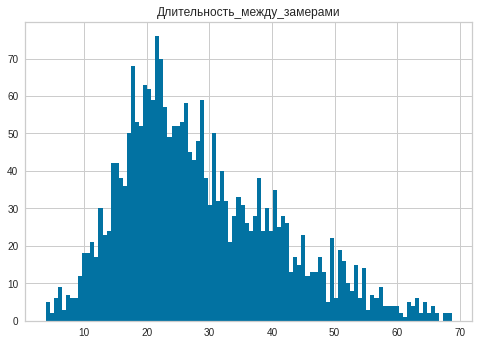

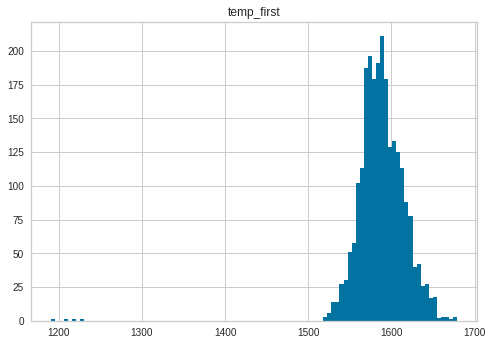

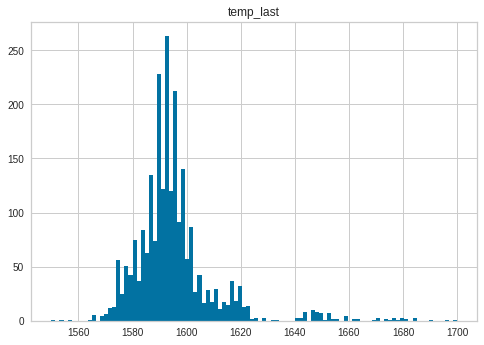

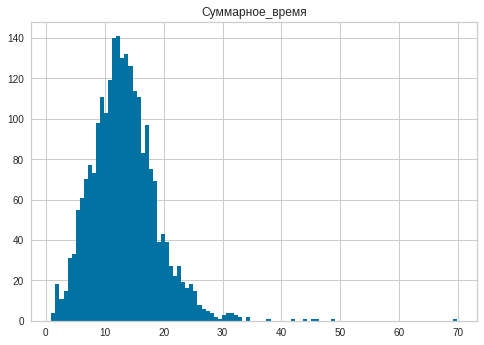

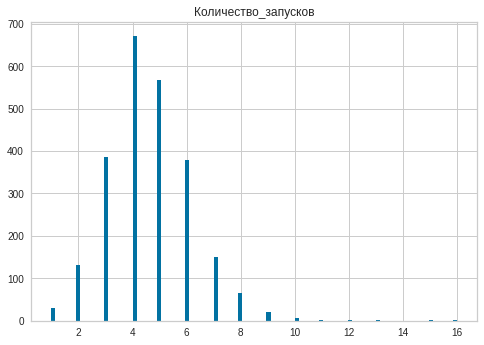

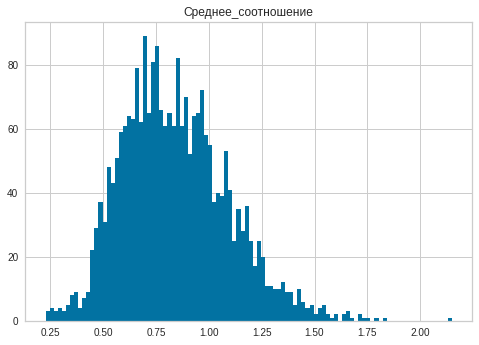

/home/vladislav/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vladislav/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


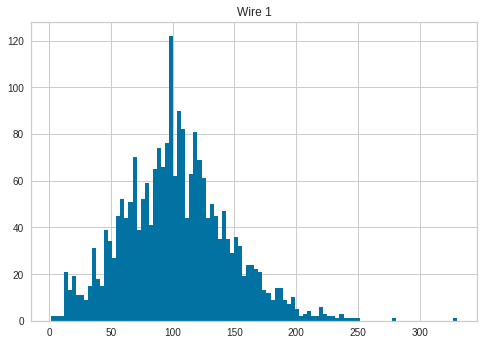

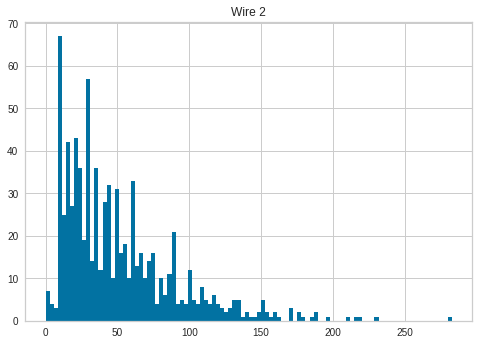

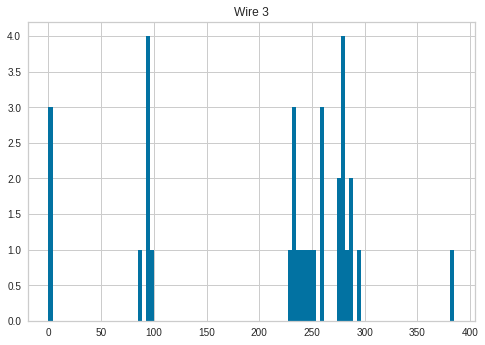

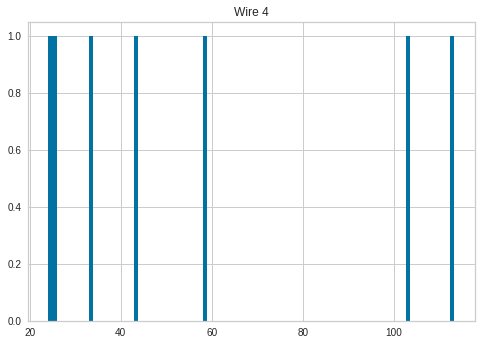

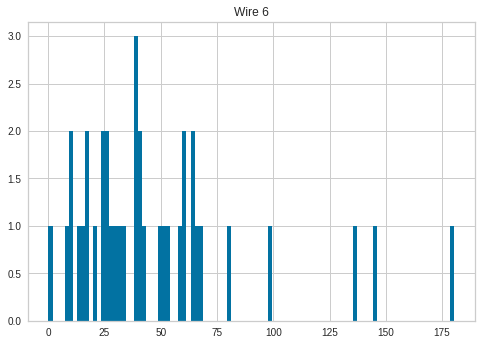

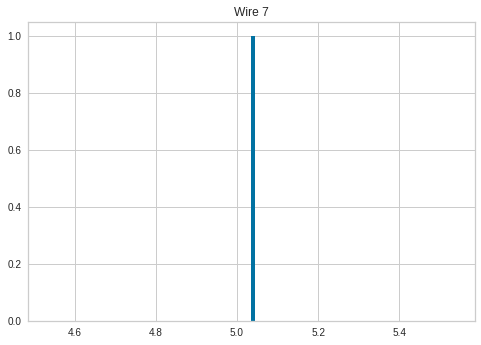

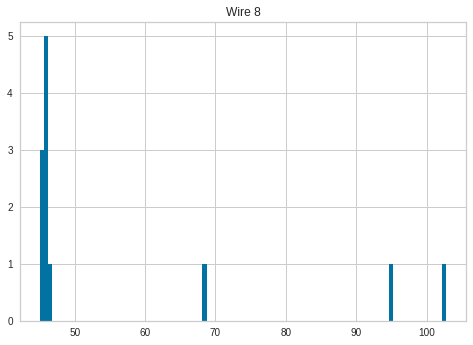

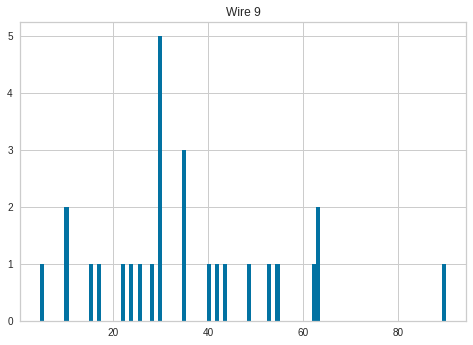

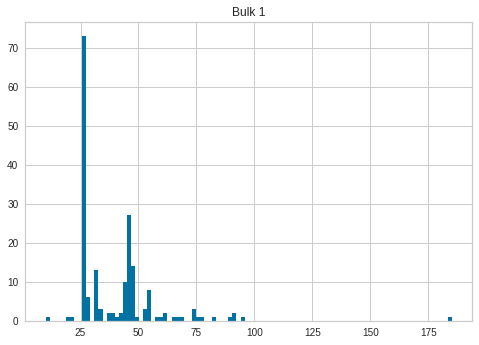

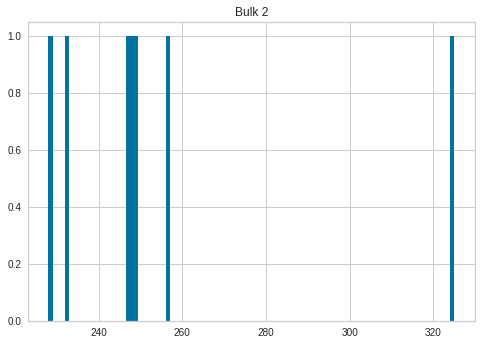

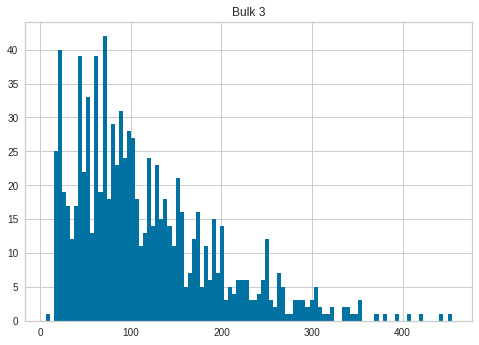

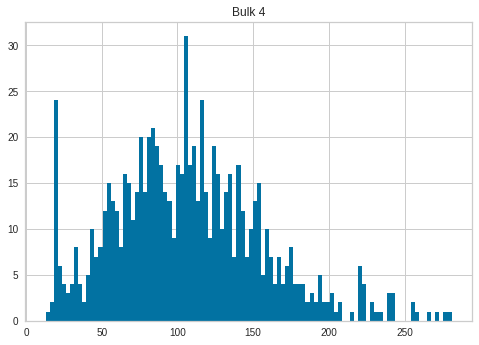

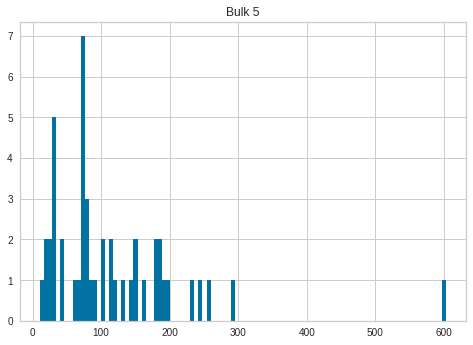

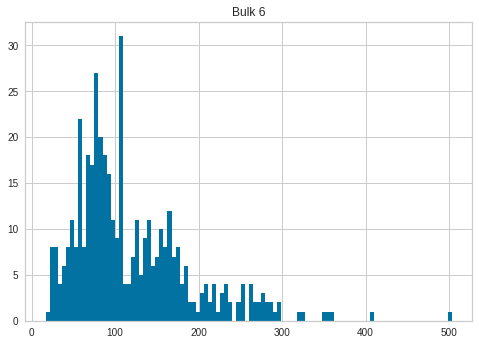

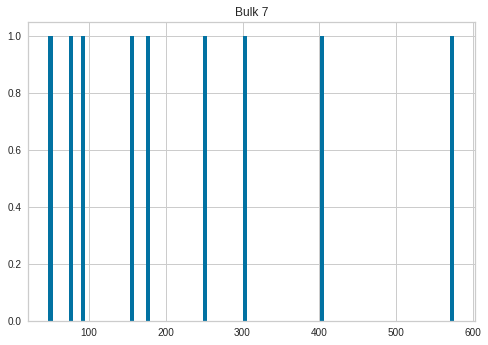

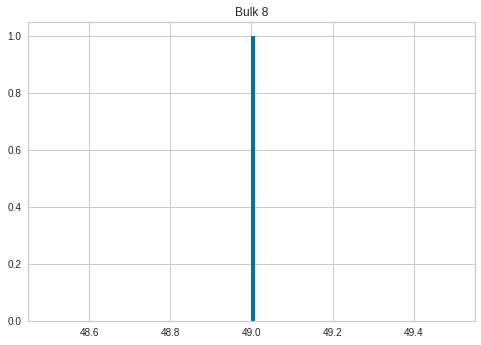

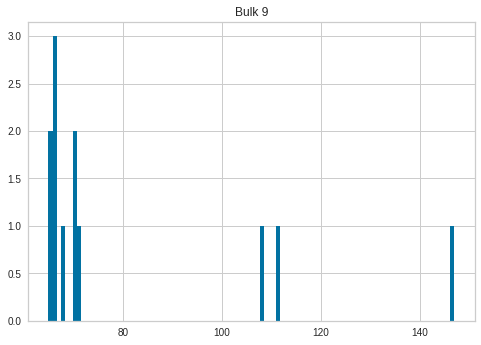

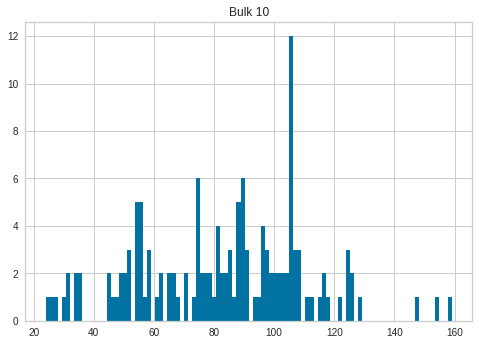

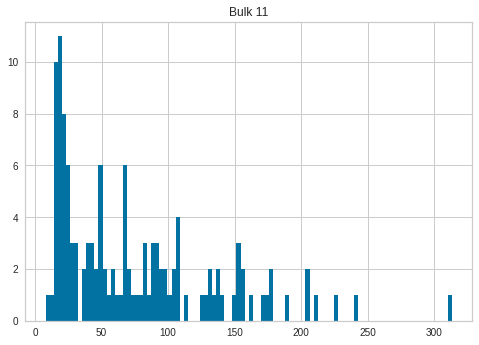

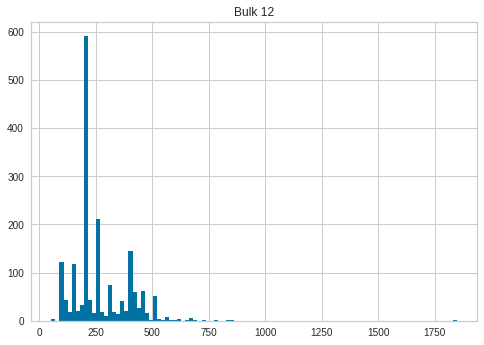

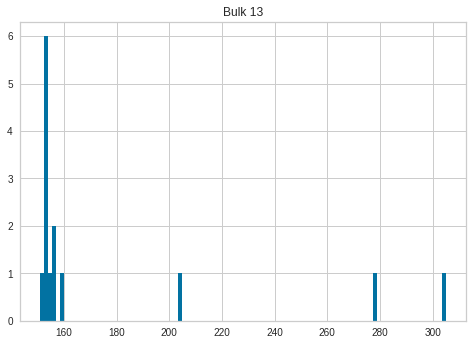

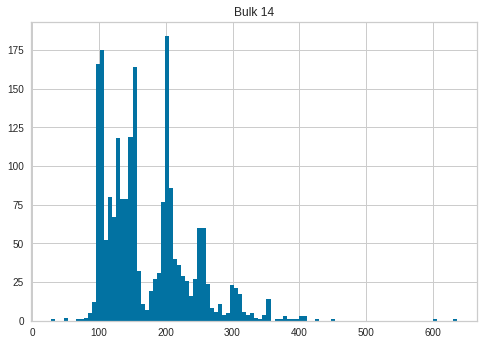

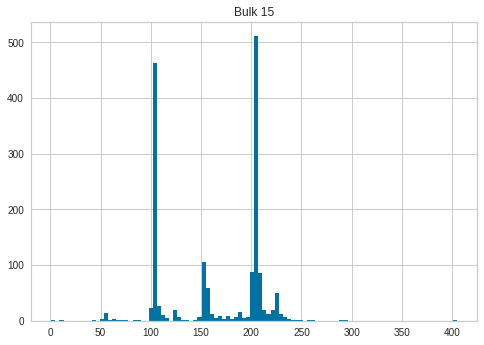

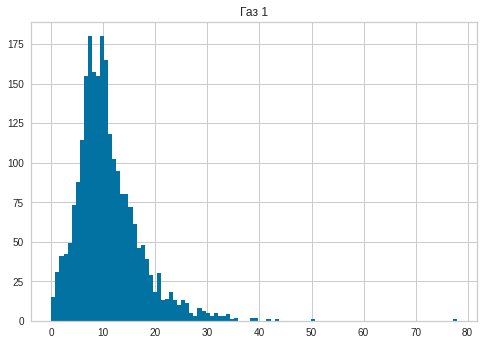

In [81]:
for i in data_all:
    plt.hist(data_all[i], bins=100)
    plt.title(i)
    plt.show()

Уберём выбросы боксплотом по признакам, в которых достаточно данных и наблюдаются серъёзные хвосты в распределениях:

In [82]:
len(data_all)

2413

In [83]:
list_ = ['temp_first', 'temp_last', 'Суммарное_время', 'Среднее_соотношение', 'Количество_запусков', 'Газ 1']
for i in list_:
    tmp = data_all[i]
    Q1 = data_all[i].quantile(0.25)
    Q3 = data_all[i].quantile(0.75)
    IQR = Q3 - Q1
    data_all = data_all.query('(@Q1 - 1.5 * @IQR) <= @tmp <= (@Q3 + 1.5 * @IQR)')

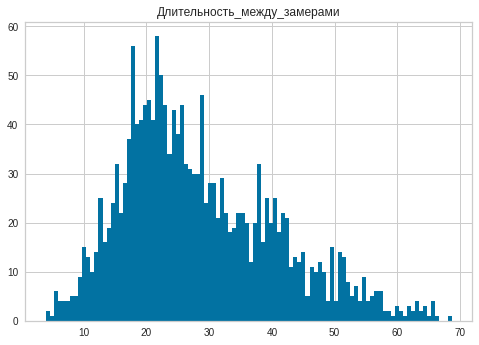

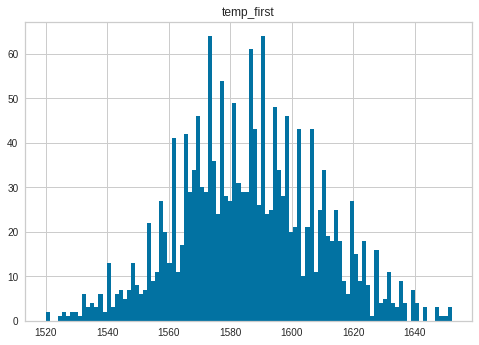

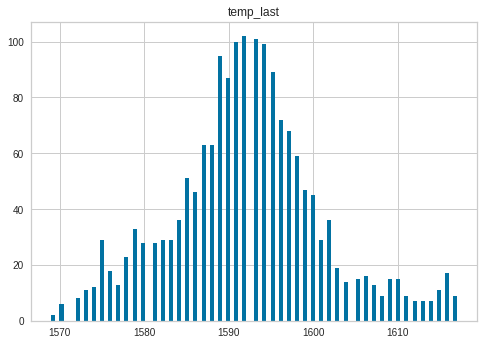

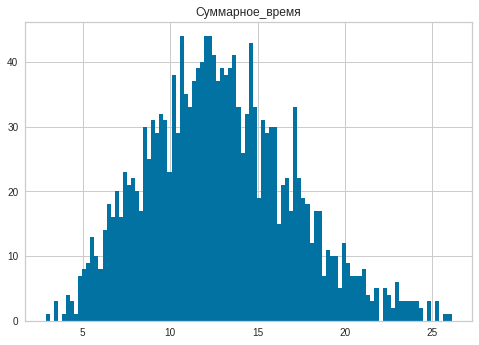

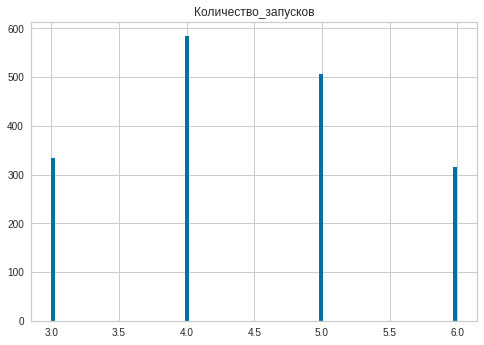

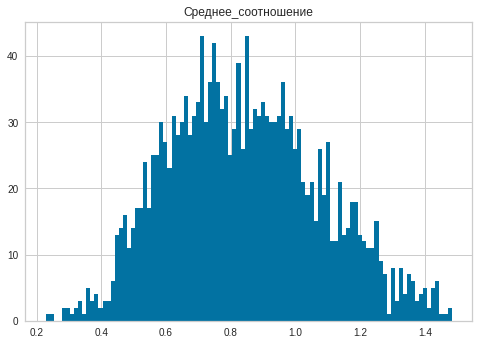

/home/vladislav/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vladislav/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


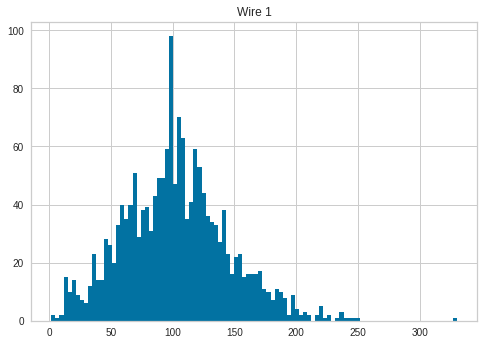

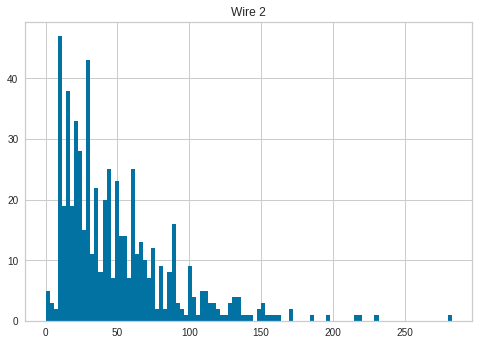

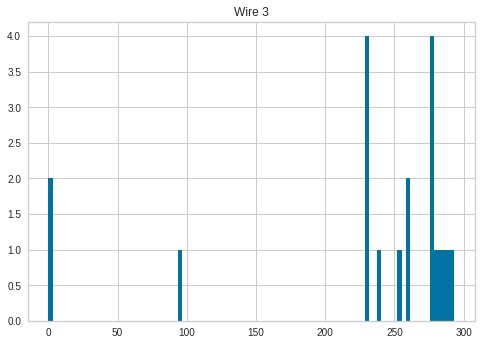

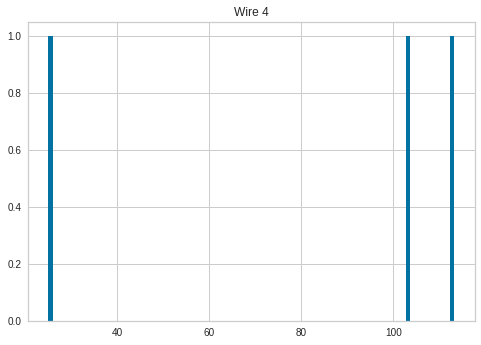

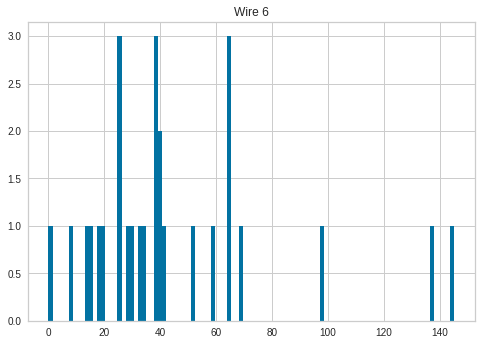

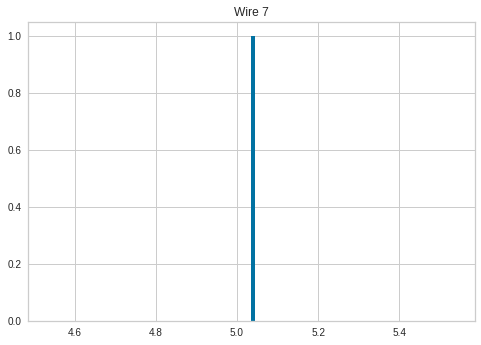

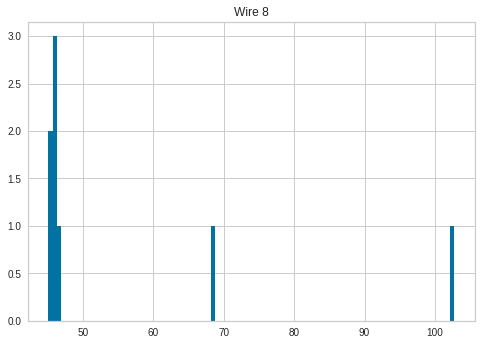

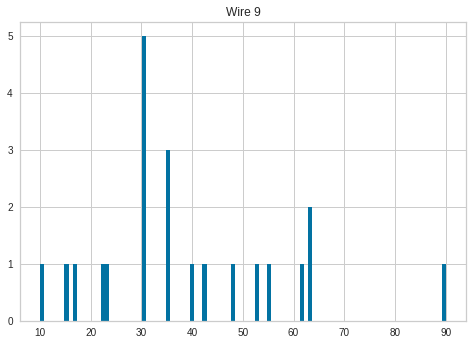

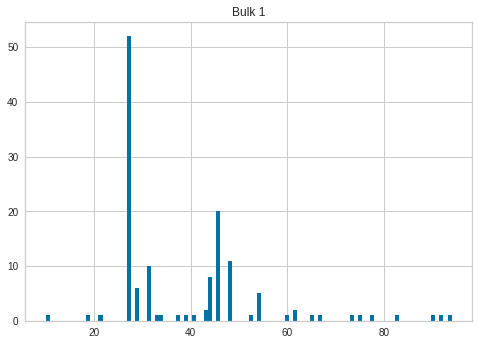

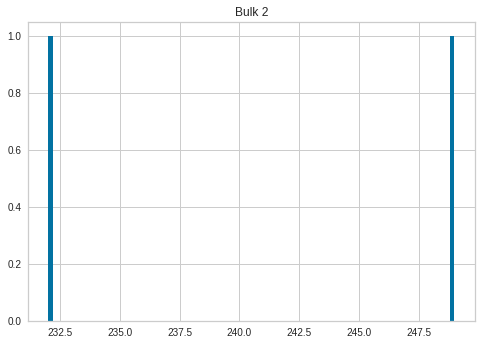

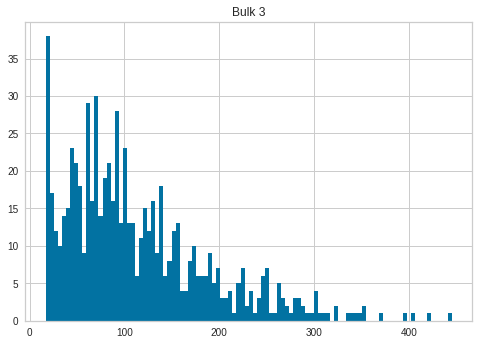

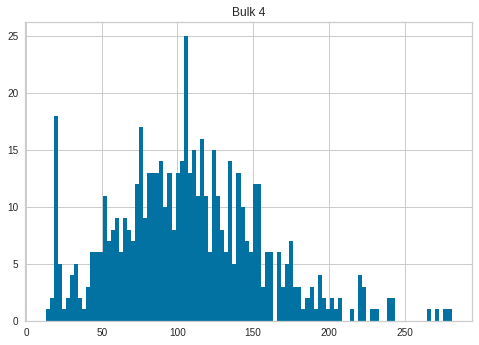

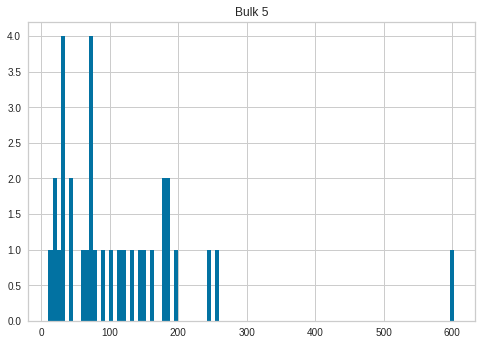

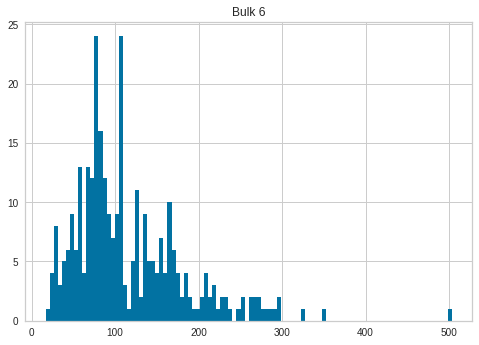

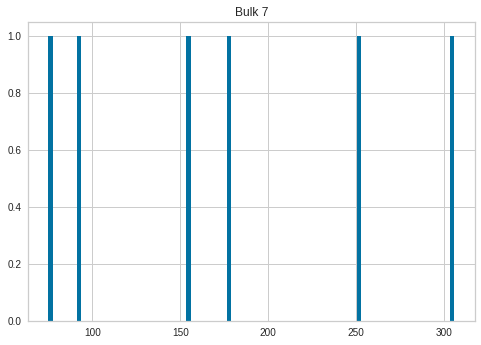

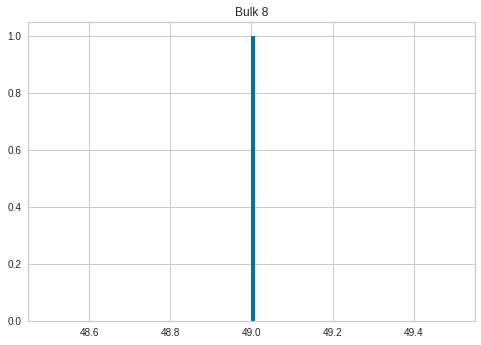

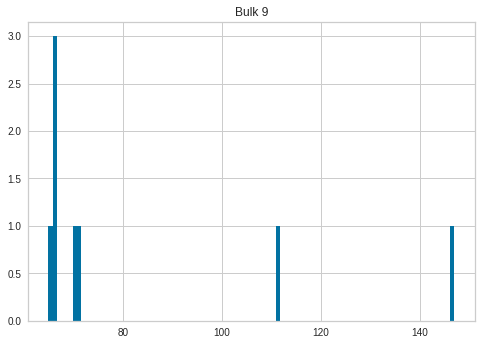

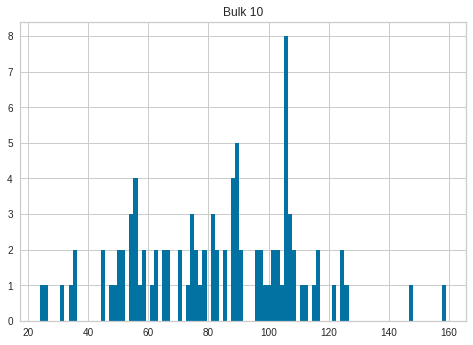

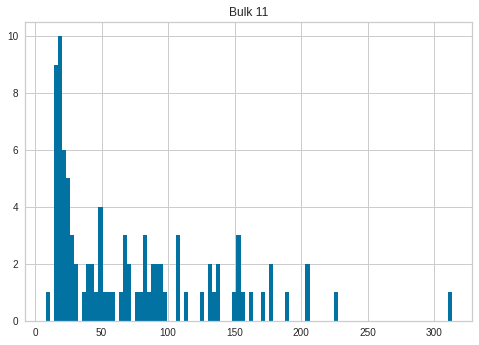

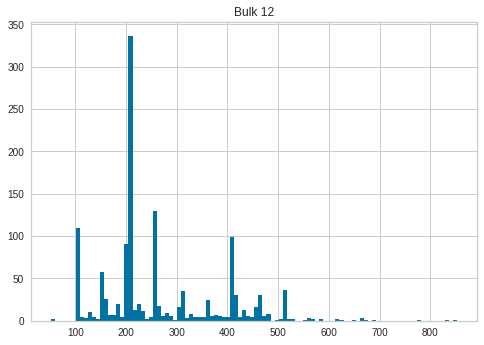

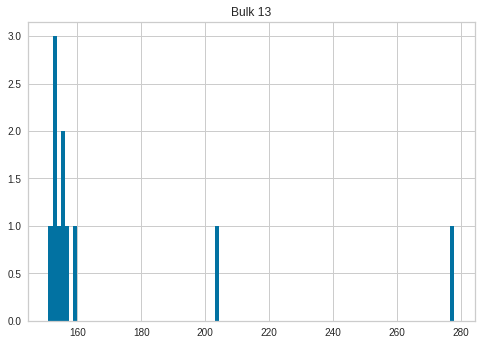

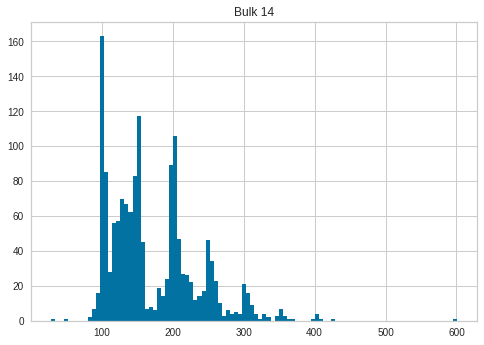

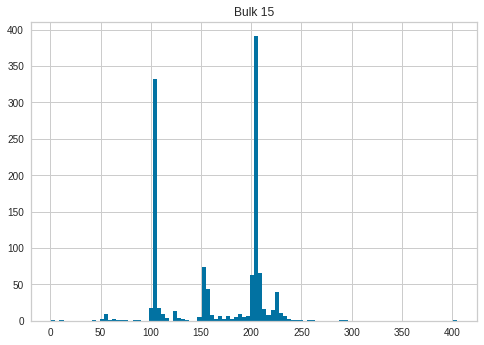

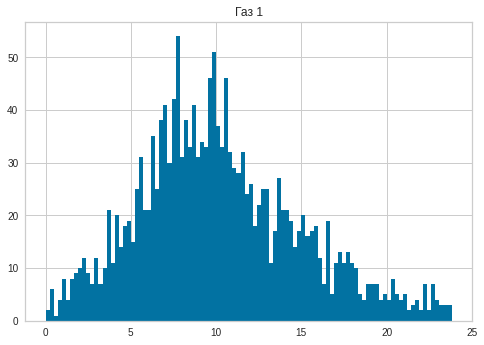

In [84]:
for i in data_all:
    plt.hist(data_all[i], bins=100)
    plt.title(i)
    plt.show()

In [85]:
display(data_all.head(15))
display(data_all.tail(15))
display(len(data_all))

,Длительность_между_замерами,temp_first,temp_last,Суммарное_время,Количество_запусков,Среднее_соотношение,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14.350000,1571,1613,13.516667,4.0,0.912304,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561
3,21.666667,1596,1599,12.350000,4.0,0.953741,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.841219
5,12.700000,1576,1602,15.866667,4.0,1.196709,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0,11.273392
6,23.083333,1543,1596,11.216667,4.0,0.746944,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0,9.836267
7,22.900000,1586,1599,15.216667,4.0,1.156847,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0,15.171553
8,15.566667,1577,1598,10.416667,5.0,0.511070,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0,8.216623
9,24.216667,1587,1592,13.750000,6.0,0.641957,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0,6.529891
10,21.650000,1574,1593,10.450000,5.0,0.572663,99.197281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,101.0,202.0,3.639128
11,33.083333,1616,1597,12.316667,4.0,0.837517,153.578873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,618.0,NaN,406.0,203.0,11.026259


,Длительность_между_замерами,temp_first,temp_last,Суммарное_время,Количество_запусков,Среднее_соотношение,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2477,51.366667,1624,1599,9.050000,4.0,0.704820,122.085609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,NaN,178.0,103.0,17.371982
2478,28.800000,1564,1594,10.216667,4.0,0.735802,100.158234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,181.0,105.0,9.248102
2479,17.716667,1576,1601,13.650000,5.0,0.847988,83.123039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,149.0,103.0,17.437711
2480,26.516667,1556,1595,9.383333,5.0,0.526097,84.215035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,149.0,104.0,14.220873
2484,28.616667,1635,1592,17.266667,6.0,0.866054,147.201599,42.103359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,510.0,NaN,209.0,104.0,13.050460
2488,35.250000,1602,1577,13.500000,6.0,0.663735,67.136162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,24.0,103.0,NaN,149.0,104.0,10.772628
2489,32.516667,1613,1579,16.716667,6.0,0.781610,126.060486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313.0,NaN,197.0,209.0,20.019526
2492,38.050000,1618,1595,13.850000,5.0,0.686464,122.172958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236.0,NaN,118.0,205.0,9.421691
2493,21.533333,1599,1594,14.600000,5.0,0.841926,75.042236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.0,NaN,119.0,155.0,3.983053


1740

In [86]:
checked_corr = []
pre_drop_list = []
pd.options.mode.chained_assignment = None
for i in data_all:
    for j in data_all:
        corr = data_all[i].corr(data_all[j], method='spearman')
        if corr not in checked_corr and i != j and 0.7 < corr or corr < -0.7:
            checked_corr.append(corr)
            print(f'Кореляция {i} с {j} = {corr}')
            pre_drop_list.append([i, j])
print(checked_corr)

Кореляция Длительность_между_замерами с Wire 4 = 1.0
Кореляция Длительность_между_замерами с Bulk 2 = 0.9999999999999999
Кореляция Длительность_между_замерами с Bulk 7 = 0.942857142857143
Кореляция temp_first с Bulk 2 = -0.9999999999999999
Кореляция temp_last с Bulk 7 = 0.8116794499134278
Кореляция Суммарное_время с Wire 4 = -1.0
Кореляция Суммарное_время с Bulk 2 = -0.9999999999999999
Кореляция Суммарное_время с Bulk 7 = -0.8285714285714287
Кореляция Количество_запусков с Bulk 2 = -0.9999999999999999
Кореляция Среднее_соотношение с Wire 4 = -1.0
Кореляция Среднее_соотношение с Bulk 2 = -0.9999999999999999
Кореляция Среднее_соотношение с Bulk 7 = -0.942857142857143
Кореляция Wire 2 с Bulk 13 = -0.7714285714285715
Кореляция Wire 4 с Суммарное_время = -1.0
Кореляция Wire 4 с Среднее_соотношение = -1.0
Кореляция Wire 6 с Bulk 1 = 0.7637626158259735
Кореляция Wire 6 с Bulk 4 = 0.8207826816681233
Кореляция Wire 6 с Bulk 5 = -0.9999999999999999
Кореляция Bulk 1 с Bulk 2 = -0.9999999999999999

/home/vladislav/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Кореляция Bulk 3 с Bulk 9 = 0.7826908981308054
Кореляция Bulk 4 с Wire 6 = 0.8207826816681234
Кореляция Bulk 5 с Wire 6 = -0.9999999999999999
Кореляция Bulk 5 с Bulk 2 = -0.9999999999999999
Кореляция Bulk 5 с Bulk 7 = -0.9999999999999999
Кореляция Bulk 7 с temp_last = 0.8116794499134279
Кореляция Bulk 7 с Суммарное_время = -0.8285714285714287
Кореляция Bulk 7 с Среднее_соотношение = -0.942857142857143
Кореляция Bulk 7 с Bulk 1 = -0.9999999999999999
Кореляция Bulk 7 с Bulk 5 = -0.9999999999999999
Кореляция Bulk 10 с Bulk 1 = -0.753702346348183
Кореляция Bulk 13 с Wire 2 = -0.7714285714285715
Кореляция Газ 1 с Bulk 2 = -0.9999999999999999
[1.0, 0.9999999999999999, 0.942857142857143, -0.9999999999999999, 0.8116794499134278, -1.0, -0.9999999999999999, -0.8285714285714287, -0.9999999999999999, -1.0, -0.9999999999999999, -0.942857142857143, -0.7714285714285715, -1.0, -1.0, 0.7637626158259735, 0.8207826816681233, -0.9999999999999999, -0.9999999999999999, -0.9999999999999999, -0.75370234634818

In [87]:
drop_list = []
for i in pre_drop_list:
    print(i[0], i[1])
    if data_all[data_all[i[0]] > 0][i[0]].count() > data_all[data_all[i[1]] > 0][i[1]].count():
        drop_list.append(i[1])
    else:
        drop_list.append(i[0])

Длительность_между_замерами Wire 4
Длительность_между_замерами Bulk 2
Длительность_между_замерами Bulk 7
temp_first Bulk 2
temp_last Bulk 7
Суммарное_время Wire 4
Суммарное_время Bulk 2
Суммарное_время Bulk 7
Количество_запусков Bulk 2
Среднее_соотношение Wire 4
Среднее_соотношение Bulk 2
Среднее_соотношение Bulk 7
Wire 2 Bulk 13
Wire 4 Суммарное_время
Wire 4 Среднее_соотношение
Wire 6 Bulk 1
Wire 6 Bulk 4
Wire 6 Bulk 5
Bulk 1 Bulk 2
Bulk 1 Bulk 7
Bulk 1 Bulk 10
Bulk 2 temp_first
Bulk 2 Суммарное_время
Bulk 2 Количество_запусков
Bulk 2 Среднее_соотношение
Bulk 2 Bulk 1
Bulk 2 Bulk 5
Bulk 2 Газ 1
Bulk 3 Bulk 9
Bulk 4 Wire 6
Bulk 5 Wire 6
Bulk 5 Bulk 2
Bulk 5 Bulk 7
Bulk 7 temp_last
Bulk 7 Суммарное_время
Bulk 7 Среднее_соотношение
Bulk 7 Bulk 1
Bulk 7 Bulk 5
Bulk 10 Bulk 1
Bulk 13 Wire 2
Газ 1 Bulk 2


In [88]:
set(drop_list)

{'Bulk 10', 'Bulk 13', 'Bulk 2', 'Bulk 7', 'Bulk 9', 'Wire 4', 'Wire 6'}

In [89]:
data_all.drop(set(drop_list), axis=1, inplace=True)

Заполним выбивающимся значением 0:

In [90]:
data_all.fillna(0, inplace=True)

In [91]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1740 entries, 1 to 2499
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Длительность_между_замерами  1740 non-null   float64
 1   temp_first                   1740 non-null   float64
 2   temp_last                    1740 non-null   float64
 3   Суммарное_время              1740 non-null   float64
 4   Количество_запусков          1740 non-null   float64
 5   Среднее_соотношение          1740 non-null   float64
 6   Wire 1                       1740 non-null   float64
 7   Wire 2                       1740 non-null   float64
 8   Wire 3                       1740 non-null   float64
 9   Wire 7                       1740 non-null   float64
 10  Wire 8                       1740 non-null   float64
 11  Wire 9                       1740 non-null   float64
 12  Bulk 1                       1740 non-null   float64
 13  Bulk 3            

In [92]:
display(data_all.head(3))
display(len(data_all))

,Длительность_между_замерами,temp_first,temp_last,Суммарное_время,Количество_запусков,Среднее_соотношение,Wire 1,Wire 2,Wire 3,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 8,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Газ 1
key,,,,,,,,,,,,,,,,,,,,,,,
1,14.350000,1571.0,1613.0,13.516667,4.0,0.912304,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561
3,21.666667,1596.0,1599.0,12.350000,4.0,0.953741,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219
5,12.700000,1576.0,1602.0,15.866667,4.0,1.196709,99.109917,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,204.0,201.0,154.0,11.273392


1740

# 5. Обучение модели.<a id='5_Обучение_модели.'></a>

Отделеним целевой признак и разбъём данные на train test:

In [93]:
data_all.reset_index(drop=True, inplace=True)

In [94]:
features = data_all.drop(['temp_last'], axis=1)
target = data_all['temp_last']

In [95]:
features_train, features_test, target_train, target_test = tts(features, target,
                                                               test_size=0.2, random_state=1)

Отмасштабируем признаки:

In [96]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Подберём параметры сначала для Линейной регрессии, как для самой базовой модели:

In [97]:
param_grid_lr = {'fit_intercept': [True, False], 'normalize': [True, False], 'n_jobs': [n for n in range(-1, 1)]}
gs_lr = gscv(lr(), param_grid=param_grid_lr, scoring='neg_mean_absolute_error', cv=5)
gs_lr.fit(features_train, target_train)
bp_lr = gs_lr.best_params_
print(f'лучший результат = {gs_lr.best_score_}. Лучшие параметры = {bp_lr}')

лучший результат = -8.83783273744793. Лучшие параметры = {'fit_intercept': True, 'n_jobs': -1, 'normalize': True}


Теперь подберём параметры и посмотрим результаты на случайном лесе, как на модели, дающей серъёзные результаты:

In [98]:
param_grid_rfr = {'n_estimators': [estim for estim in range(10, 101, 10)], 'max_depth': [depth for depth in range(5, 16, 5)]}
gs_rfr = gscv(rfr(random_state=1), param_grid=param_grid_rfr, scoring='neg_mean_absolute_error', cv=5)
gs_rfr.fit(features_train, target_train)
bp_rfr = gs_rfr.best_params_
print(f'лучший результат = {gs_rfr.best_score_}. Лучшие параметры = {bp_rfr}')

лучший результат = -6.394552012956202. Лучшие параметры = {'max_depth': 5, 'n_estimators': 100}


Попробуем модель с градиентным бустингом LightGBM от Microsoft, как основу бустинга:

In [99]:
param_grid_lgbmr = {'max_depth':[depth for depth in range(-1, 30, 10)], 'n_estimators': [estim for estim in range(10, 51, 10)], 'num_leaves': [leav for leav in range(30, 60, 10)]}
gs_lgbmr = gscv(LGBMRegressor(random_state=1), param_grid=param_grid_lgbmr, scoring='neg_mean_absolute_error', cv=5)
gs_lgbmr.fit(features_train, target_train)
bp_lgbmr = gs_lgbmr.best_params_
print(f'лучший результат = {gs_lgbmr.best_score_}. Лучшие параметры = {bp_lgbmr}')

лучший результат = -6.458643627021902. Лучшие параметры = {'max_depth': -1, 'n_estimators': 10, 'num_leaves': 40}


На последок возьмём модель с градиентным бустингом от Яндекса, как самую быструю, у которой лучшие параметры по умолчанию.

In [100]:
param_grid_cat = {'iterations':[10, 100, 500]}
gs_cat = gscv(CatBoostRegressor(loss_function='MAE', random_state=1, verbose=False), param_grid=param_grid_cat, scoring='neg_mean_absolute_error', cv=5)
gs_cat.fit(features_train, target_train)
bp_cat = gs_cat.best_params_
print(f'лучший результат = {gs_cat.best_score_}. Лучшие параметры = {bp_cat}')

лучший результат = -6.416352382173566. Лучшие параметры = {'iterations': 100}


Наилучшие результаты показала модели Случайный лес и КэтБуст. Обучим их и проверим результаты на тестовой выборке:

rfr

In [101]:
model_rfr = rfr(n_estimators=bp_rfr['n_estimators'], max_depth=bp_rfr['max_depth'], random_state=1)
model_rfr.fit(features_train, target_train)
pred = model_rfr.predict(features_test)
mae(target_test, pred)

6.015667105269957

cbr

In [102]:
model_cbr = CatBoostRegressor(loss_function='MAE', iterations=bp_cat['iterations'], random_state=1)
model_cbr.fit(features_train, target_train, verbose=False)
pred = model_cbr.predict(features_test)
mae(target_test, pred)

5.929060883516477

На тестовой выборке немного лучше показала себя КэтБуст.

Посмотрим на знеаченние признаков в датасетах RandomForestRegressor и CatBoostRegressor.  
Сначала RandomForestRegressor:

/home/vladislav/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


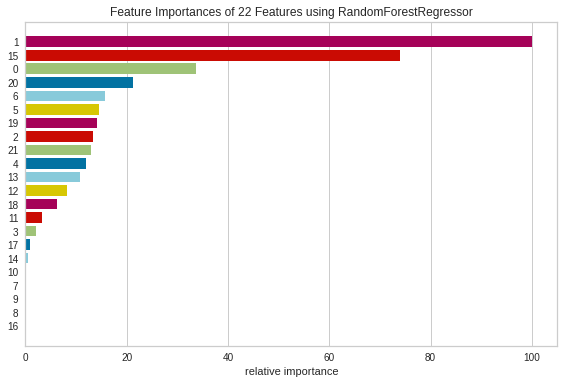

<AxesSubplot:title={'center':'Feature Importances of 22 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [103]:
model_rfr2 = rfr(n_estimators=bp_rfr['n_estimators'], max_depth=bp_rfr['max_depth'], random_state=1)
viz = FeatureImportances(model_rfr2)
viz.fit(features_train, target_train)
viz.show()

Признак(0): Длительность_между_замерами, Значимость: 0.0981
Признак(1): temp_first, Значимость: 0.29103
Признак(2): Суммарное_время, Значимость: 0.03892
Признак(3): Количество_запусков, Значимость: 0.00627
Признак(4): Среднее_соотношение, Значимость: 0.03469
Признак(5): Wire 1, Значимость: 0.04225
Признак(6): Wire 2, Значимость: 0.04592
Признак(7): Wire 3, Значимость: 0.00032
Признак(8): Wire 7, Значимость: 0.0
Признак(9): Wire 8, Значимость: 0.0
Признак(10): Wire 9, Значимость: 0.0005
Признак(11): Bulk 1, Значимость: 0.00952
Признак(12): Bulk 3, Значимость: 0.02364
Признак(13): Bulk 4, Значимость: 0.03161
Признак(14): Bulk 5, Значимость: 0.00173
Признак(15): Bulk 6, Значимость: 0.21495
Признак(16): Bulk 8, Значимость: 0.0
Признак(17): Bulk 11, Значимость: 0.00234
Признак(18): Bulk 12, Значимость: 0.01822
Признак(19): Bulk 14, Значимость: 0.04087
Признак(20): Bulk 15, Значимость: 0.06173
Признак(21): Газ 1, Значимость: 0.0374


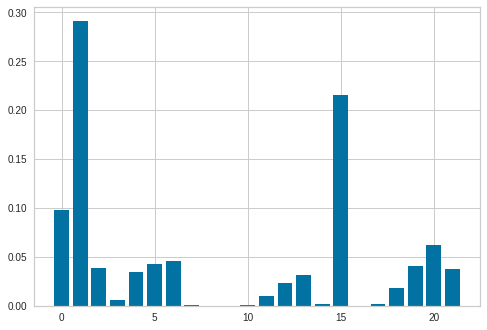

In [104]:
importance_rfr = model_rfr.feature_importances_
for i in range(len(importance_rfr)):
    print(f'Признак({i}): {features.columns[i]}, Значимость: {round(importance_rfr[i], 5)}')
plt.bar([x for x in range(len(importance_rfr))], importance_rfr)
plt.show()

Из графика видно, что наиболее важны признаки: temp_first(Первонапчальная температура), Bulk 6,  Длительность_между_замерами и Bulk 15. Наименее выжны Wire 7, Wire 8, Wire 9, Bulk 5 и Bulk 8.

Признак(0): Длительность_между_замерами, Значимость: 8.01365
Признак(1): temp_first, Значимость: 23.02767
Признак(2): Суммарное_время, Значимость: 3.94647
Признак(3): Количество_запусков, Значимость: 2.1688
Признак(4): Среднее_соотношение, Значимость: 3.11183
Признак(5): Wire 1, Значимость: 5.17658
Признак(6): Wire 2, Значимость: 8.04632
Признак(7): Wire 3, Значимость: 0.31802
Признак(8): Wire 7, Значимость: 0.0
Признак(9): Wire 8, Значимость: 0.00783
Признак(10): Wire 9, Значимость: 0.07885
Признак(11): Bulk 1, Значимость: 1.44639
Признак(12): Bulk 3, Значимость: 2.64301
Признак(13): Bulk 4, Значимость: 3.71727
Признак(14): Bulk 5, Значимость: 0.90566
Признак(15): Bulk 6, Значимость: 11.65923
Признак(16): Bulk 8, Значимость: 0.0
Признак(17): Bulk 11, Значимость: 0.79359
Признак(18): Bulk 12, Значимость: 5.80951
Признак(19): Bulk 14, Значимость: 5.83819
Признак(20): Bulk 15, Значимость: 8.45811
Признак(21): Газ 1, Значимость: 4.83301


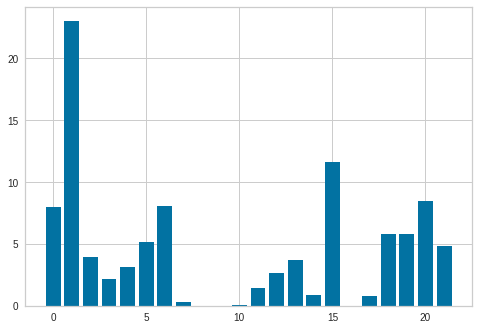

In [105]:
importance_cbr = model_cbr.feature_importances_
for i in range(len(importance_cbr)):
    print(f'Признак({i}): {features.columns[i]}, Значимость: {round(importance_cbr[i], 5)}')
plt.bar([x for x in range(len(importance_cbr))], importance_cbr)
plt.show()

Для CatBoostRegressorважнее всего: temp_first(Первонапчальная температура)(1), Bulk 6(15), Длительность_между_замерами(0) и Bulk 15(20). Наименее выжны Wire 7(8), Wire 8(9), Wire 9(10), Bulk 5(14) и Bulk 8(16).

# 6. Выводы.<a id='6_Выводы.'></a>

Были изучены данные, проведена предобработка. Расчитаны необходимые для модели дополнительные признаки. После анализа данных, можно сказать, что в данных были выбросы, также примерно треть данных пришлось откинуть из-за отсутсвия конечной, либо начальной температуры, а это целевой признак. Есть и лишняя информация, которую не получится использовать для обучения модели, например промежуточные температуры и данные о времени. По графикам можно сделать вывод, что выбросы в виде хвостов присутсвуют, но не в огромных количествах. Некоторые признаки коррелируют. Для предсказаний были выбраны модели:  

- LinearRegression
- RandomForestRegressor
- LGBMRegressor
- CatBoostRegressor  

Наилучший результат на кросс валидации показала RandomForestRegressor с результатом MAE = 6.394552012956202, но на тестовой выборке лучший результат за CatBoostRegressor = 5.929060883516477. Следует сделать доп проверку, когда будет большой объём данных. На данный момент желательно выбрать CatBoostRegressor, как более прогрессивную модель с более точными перспекивными алгоритмами. Обучение маделей показало, что самые важные признаки для лучших моделей:  
- Первонапчальная температура, Bulk 6, Длительность_между_замерами и Bulk 15 для RandomForestRegressor.  
- Первонапчальная температура, Bulk 6, Длительность_между_замерами и Bulk 15 для CatBoostRegressor.  

Графики важности признаков этих моделей во многом схожи, но не идентичны.наибольшие разлиия видны на признаках с 16 по 20. Признак с наибольшим влиянием - начальная температура. Необходимо работать над контролем и регулированием этой температуры для возможности снижения затрат электроэнергии.

# План работ:  
- [1. Первый взглад на данные.](#1_Первый_взглад_на_данные.)
- [2. Предобработка данных.](#2_Предобработка_данных.)
- [3. Задание.](#3_Задание.)
- [4. Подготовка данных.](#4_Подготовка_данных.)
- [5. Обучение модели.](#5_Обучение_модели.)
- [6. Выводы.](#6_Выводы.)